In [1]:
import pandas as pd
import sys
import numpy as np
import string
import os
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils.estimator_checks import check_estimator
import matplotlib.pyplot as plt

	

from xgboost import XGBRegressor, XGBClassifier

In [2]:
os.path.abspath('..')
sys.path.append(os.path.abspath('..'))


In [3]:
import importlib

import transformers
from transformers.columns_setter_transformer import ColumnsSetterTransformer
from transformers.extract_set_column_transformer import ExtractSetColumnsTransformer
from transformers.select_transformer import SelectTransformer
from transformers.select_by_index_transformer import SelectByIndexTransformer
from transformers.one_hot_encoder_transformer import OneHotEncoderTransformer
from transformers.select_by_mask_transformer import SelectByMaskTransformer
from transformers.my_turns_transformation import MyTurnsTransformation
from transformers.classify_set_transformer import ClassifySetTransformer
from transformers.name_dropper_transformer import NameDropperTransformer
from transformers.regression_wrapper_transformer import RegressionWrapperTransformer
from transformers.regression_2_wrapper_transformer import Regression2WrapperTransformer

importlib.reload(transformers)
importlib.reload(transformers.columns_setter_transformer)
importlib.reload(transformers.extract_set_column_transformer)
importlib.reload(transformers.select_transformer)
importlib.reload(transformers.select_by_index_transformer)
importlib.reload(transformers.one_hot_encoder_transformer)
importlib.reload(transformers.select_by_mask_transformer)
importlib.reload(transformers.my_turns_transformation)
importlib.reload(transformers.classify_set_transformer)
importlib.reload(transformers.regression_wrapper_transformer)
importlib.reload(transformers.regression_2_wrapper_transformer)




import functions
from functions.is_bot_extractor import IsBotExtarctor
importlib.reload(functions)
importlib.reload(functions.is_bot_extractor)

import builders
from builders.preprocessor_builder import PreprocessorBuilder
importlib.reload(builders)
importlib.reload(builders.preprocessor_builder)

import searcher
import searcher_results_orgenizer
from searcher_results_orgenizer import SearcherResultsOrgenizer
importlib.reload(searcher)
importlib.reload(searcher_results_orgenizer)







<module 'searcher_results_orgenizer' from 'c:\\Users\\Bina4\\Desktop\\Guy_hafifa\\scrabble\\searcher_results_orgenizer.py'>

In [4]:
games = pd.read_csv('../data/games.csv', index_col='game_id')
train = pd.read_csv('../data/train.csv', index_col='game_id')
turns = pd.read_csv('../data/turns.csv', index_col='game_id')


In [5]:
G_NAME = 'games'
T_NAME = 'turns'
DATA_NAME = 'train'

names = ['BetterBot', 'STEEBot', 'HastyBot']



features = np.load('../feature_selection_consts/columns.npy', allow_pickle=True)
# features.append('')

prePipe = Pipeline([
                    ('get_relavent_turns', SelectByIndexTransformer(train.index.unique(), target=T_NAME)),
                     ('get_relavent_games',  SelectByIndexTransformer(train.index.unique(), target=G_NAME)),
                     ('train_set_is_player', ExtractSetColumnsTransformer({'is_player': IsBotExtarctor(names, 'nickname', True)},
                                                                           src=DATA_NAME, dest=DATA_NAME)),
                     ('get_bot_rating', ExtractSetColumnsTransformer({'bot_rating': lambda train: train[~train['is_player']]['rating']},
                                                                      src=DATA_NAME, dest=G_NAME)),
                     ('get_bots_names', ExtractSetColumnsTransformer({'bot_name': lambda train: train[~train['is_player']]['nickname']},
                                                                     src=DATA_NAME, dest=G_NAME)),
                    ('data_drop_bot_rating', SelectByMaskTransformer('is_player', target=DATA_NAME)),
                    ])
preprocessor = PreprocessorBuilder(games, G_NAME, turns, T_NAME, prePipe).build()
n_games, n_turns, n_ratings = preprocessor.process(train, DATA_NAME)
t_turns = pd.read_csv('../data/fs_turns.csv', index_col='game_id') # MyTurnsTransformation().transform(n_turns)
n_data = n_games.merge(t_turns, left_index=True, right_index=True)



In [7]:
regressor_steps = [('extract_first', ColumnsSetterTransformer({'is_bot_first': IsBotExtarctor(names, name_col='first')})),
                   ('hot', OneHotEncoderTransformer({'time_control_name': games['time_control_name'].unique(),
                                                     'game_end_reason':  games['game_end_reason'].unique(),
                                                     'lexicon':  games['lexicon'].unique(),
                                                     'rating_mode':  games['rating_mode'].unique(),
                                                     'bot_name': names}
                                                        )),
                   ('select_col', SelectTransformer(features)),
                   ('xgb', XGBRegressor(random_state=0,
                                        max_depth=7, min_child_weight=1,
                                        gamma=0,
                                        subsample=1, colsample_bytree=1,
                                        reg_alpha=0.00005, reg_lambda=1,
                                        learning_rate=np.sqrt(3)/10
                                        )),                                              
                   ]



In [28]:
regressor = Pipeline(regressor_steps)
cv_res = cross_validate(regressor, n_data,n_ratings, cv=5,
                         scoring=('neg_root_mean_squared_error'),
                         return_train_score=True,)

In [29]:
pd.DataFrame(cv_res).mean()


fit_time         5.455700
score_time       0.119220
test_score    -105.045024
train_score    -85.112928
dtype: float64

In [23]:
regressor = Pipeline(regressor_steps)
regressor.fit(n_data, n_ratings)

Pipeline(steps=[('extract_first',
                 ColumnsSetterTransformer(columns={'is_bot_first': <functions.is_bot_extractor.IsBotExtarctor object at 0x0000025B3DACEAC0>})),
                ('hot',
                 OneHotEncoderTransformer(columns={'bot_name': ['BetterBot',
                                                                'STEEBot',
                                                                'HastyBot'],
                                                   'game_end_reason': array(['STANDARD', 'RESIGNED', 'TIME', 'CONSECUTIVE_ZEROES'], dtype=object),
                                                   'lexicon': array(['...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.17320508075688773, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...))])

In [9]:
prediction = pd.Series(regressor.predict(n_data), index=n_ratings.index)

In [10]:
mean_squared_error(n_ratings, prediction, squared=False)

87.01702826366557

In [11]:
abs_error = np.abs(prediction - n_ratings)
error = prediction - n_ratings

In [34]:
abs_error.describe()

count    50410.000000
mean        59.767238
std         63.244919
min          0.000244
25%         12.078369
50%         40.841003
75%         86.747253
max        608.116089
dtype: float64

In [35]:
prediction.describe()

count    50410.000000
mean      1790.332886
std        204.806305
min       1058.774292
25%       1614.981903
50%       1816.444092
75%       1975.551117
max       2463.072510
dtype: float64

In [36]:
n_ratings.describe()

count    50410.000000
mean      1790.322674
std        229.662441
min       1033.000000
25%       1582.000000
50%       1818.000000
75%       1982.000000
max       2510.000000
Name: rating, dtype: float64

<Axes: >

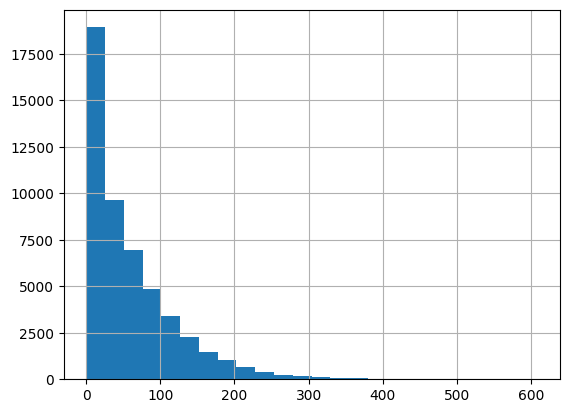

In [37]:
abs_error.hist(bins=24)

In [38]:
(abs_error < 100).sum() / abs_error.size

0.7974608212656219

In [39]:
(abs_error > 200).sum()

1936

In [40]:
n_games[abs_error>200].describe()

winner  initial_time_seconds  increment_seconds  \
count  1936.000000           1936.000000        1936.000000   
mean      0.316632           1204.927686           0.138430   
std       0.471900            530.680899           2.732038   
min      -1.000000            180.000000           0.000000   
25%       0.000000            960.000000           0.000000   
50%       0.000000           1200.000000           0.000000   
75%       1.000000           1200.000000           0.000000   
max       1.000000           3600.000000          60.000000   

       max_overtime_minutes  game_duration_seconds   bot_rating  
count           1936.000000            1936.000000  1936.000000  
mean               1.133264             584.096847  2031.152893  
std                1.009418             281.676558   145.393588  
min                0.000000             120.440364  1594.000000  
25%                1.000000             378.638119  1956.000000  
50%                1.000000             521.300345  2033.000000  
75%                1.000000             741.078766  2137.000000  
max               10.000000            2087.298744  2341.000000

In [13]:
data = n_games.assign(**{'rating': n_ratings, 'abs_error': abs_error, 'pred': prediction, 'error': error})

In [42]:
data['pred'].describe()

count    50410.000000
mean      1790.332886
std        204.806305
min       1058.774292
25%       1614.981903
50%       1816.444092
75%       1975.551117
max       2463.072510
Name: pred, dtype: float64

In [43]:
data['rating'].describe()

count    50410.000000
mean      1790.322674
std        229.662441
min       1033.000000
25%       1582.000000
50%       1818.000000
75%       1982.000000
max       2510.000000
Name: rating, dtype: float64

In [44]:
data['error'].describe()

count    50410.000000
mean         0.010319
std         87.017891
min       -572.370117
25%        -43.584747
50%         -0.315369
75%         38.044983
max        608.116089
Name: error, dtype: float64

In [45]:
data[data['rating'] > 1600]['error'].describe()

count    36798.000000
mean       -14.047954
std         86.203114
min       -572.370117
25%        -63.629700
50%        -13.708374
75%         33.956818
max        423.785156
Name: error, dtype: float64

In [46]:
data[(data['rating'] < 1600)]['error'].describe()

count    13561.000000
mean        38.039837
std         77.321371
min       -179.663940
25%         -0.785034
50%          2.565552
75%         55.780029
max        608.116089
Name: error, dtype: float64

In [47]:
data[(data['rating'] < 1600) & (data['rating'] > 1400)]['error'].describe()

count    12285.000000
mean        30.521640
std         69.607846
min       -179.663940
25%         -0.985229
50%          1.926514
75%         39.103638
max        595.853027
Name: error, dtype: float64

In [48]:
(n_ratings < 1600).astype(int)

game_id
1        1
3        0
4        1
5        1
6        0
        ..
72767    1
72770    1
72771    1
72772    1
72773    0
Name: rating, Length: 50410, dtype: int32

<Axes: xlabel='rating', ylabel='error'>

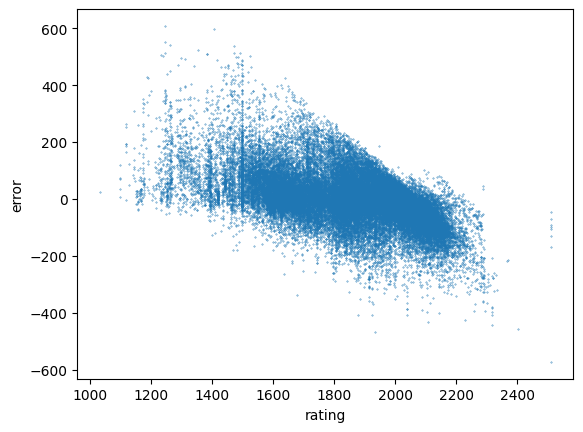

In [49]:
data.plot.scatter('rating', 'error', 0.1)

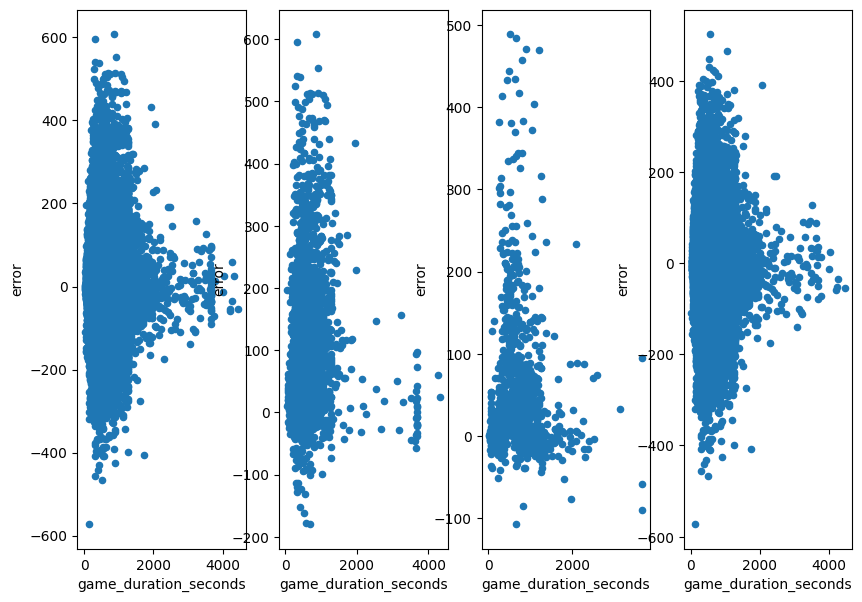

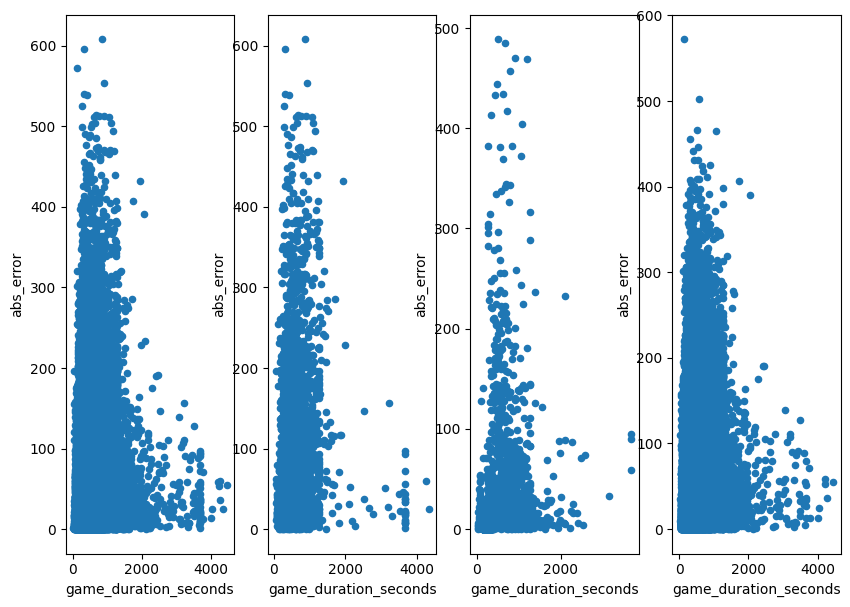

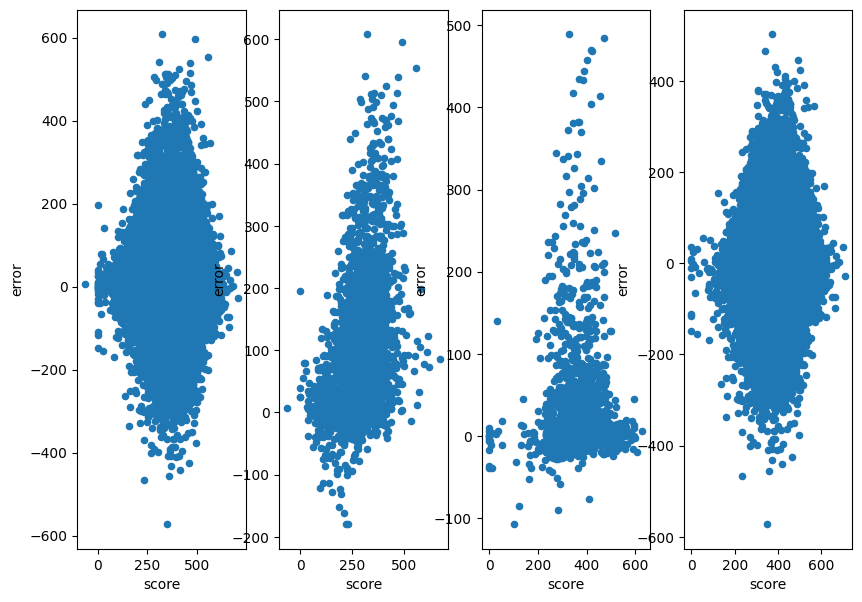

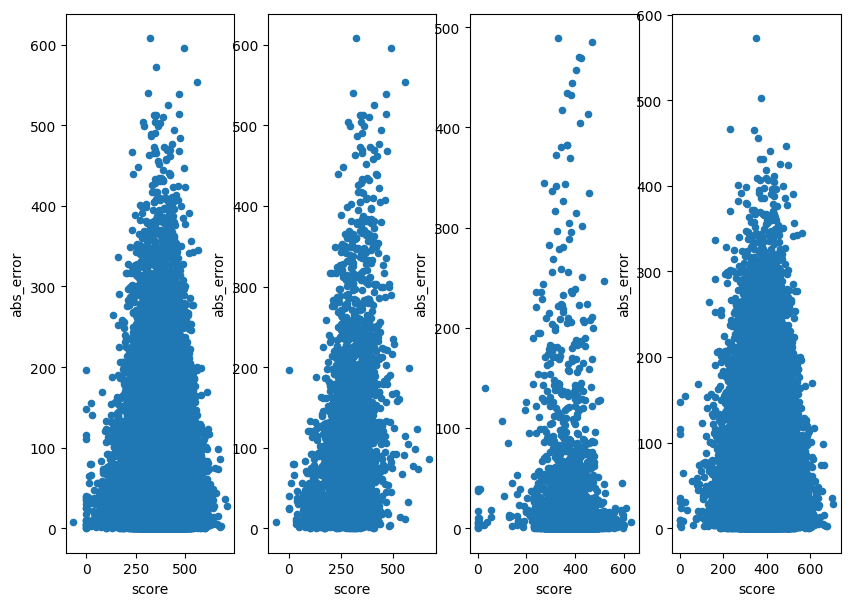

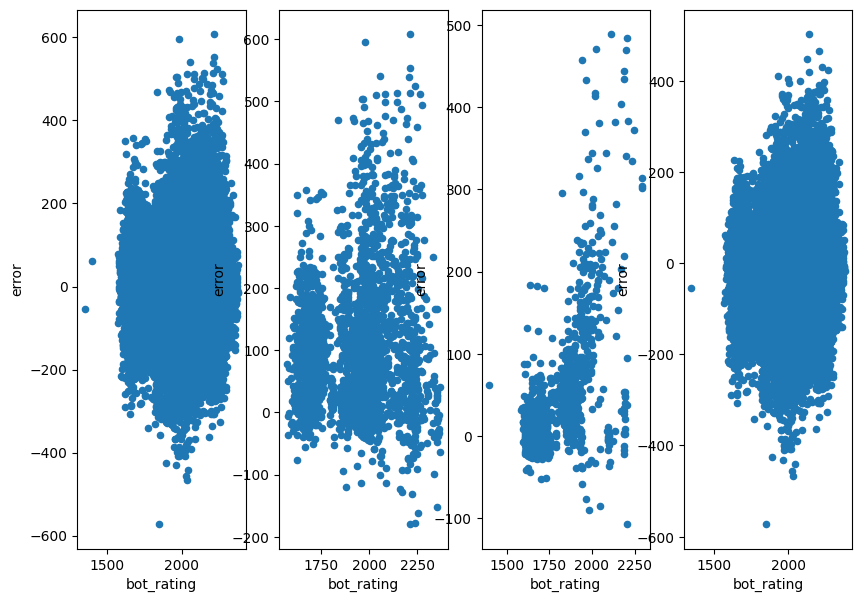

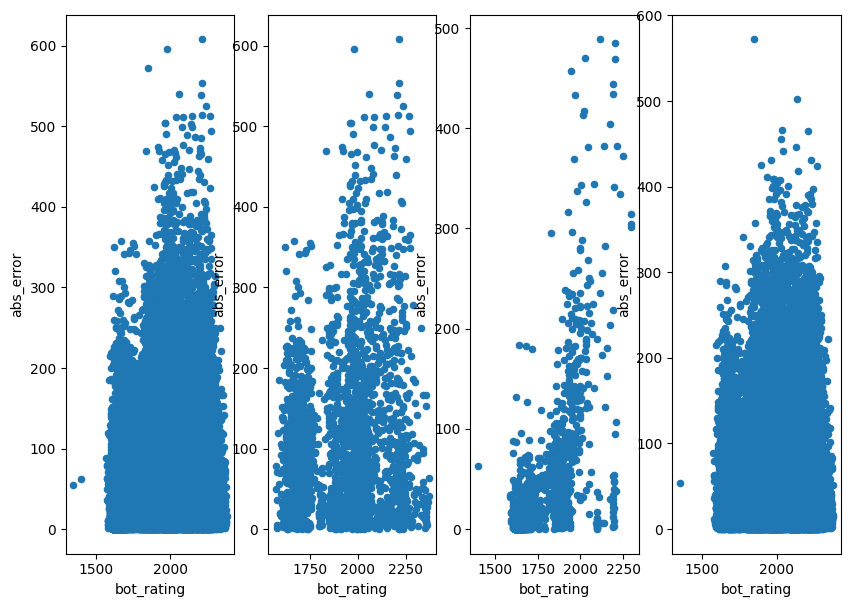

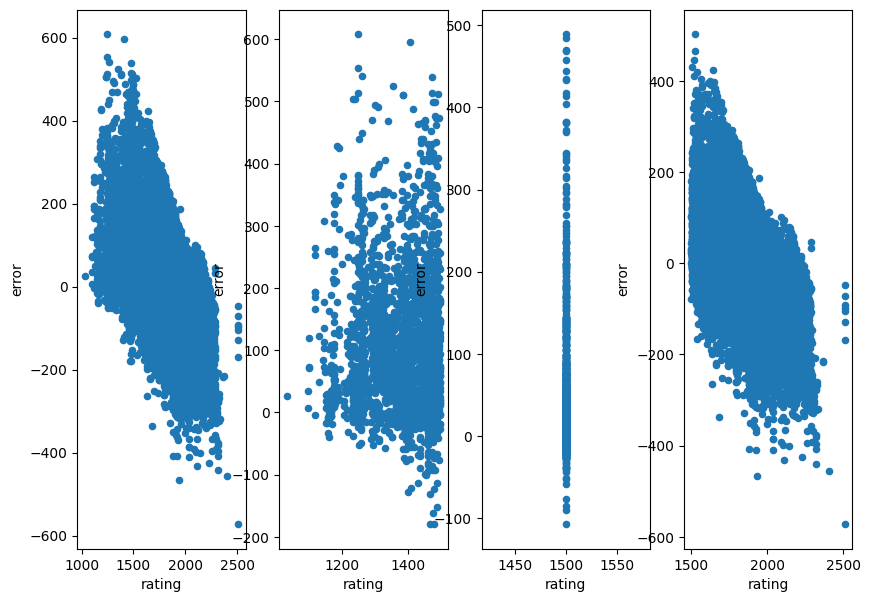

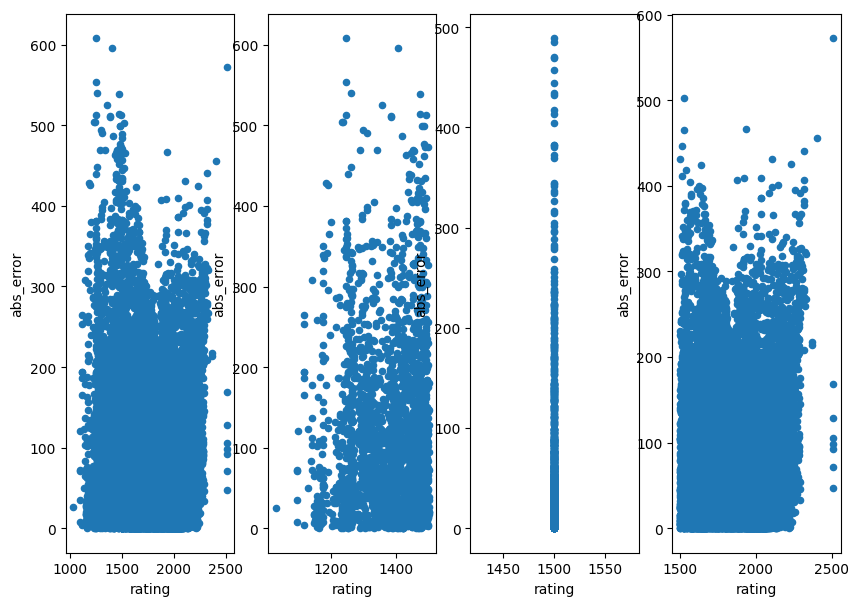

In [18]:
numerical = ['game_duration_seconds', 'score', 'bot_rating', 'rating']
more_mask = (data['rating'] > 1500)
less_mask = (data['rating'] < 1500)
both_mask = ~more_mask & ~less_mask

for i, check in enumerate(numerical):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
    data[[check, 'error']].plot.scatter(x=check, y='error', ax=axes[0])
    data[less_mask][[check, 'error']].plot.scatter(x=check, y='error', ax=axes[1])
    data[both_mask][[check, 'error']].plot.scatter(x=check, y='error', ax=axes[2])
    data[more_mask][[check, 'error']].plot.scatter(x=check, y='error', ax=axes[3])
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
    data[[check, 'abs_error']].plot.scatter(x=check, y='abs_error', ax=axes[0])
    data[less_mask][[check, 'abs_error']].plot.scatter(x=check, y='abs_error', ax=axes[1])
    data[both_mask][[check, 'abs_error']].plot.scatter(x=check, y='abs_error', ax=axes[2])
    data[more_mask][[check, 'abs_error']].plot.scatter(x=check, y='abs_error', ax=axes[3])

In [50]:
cats = ['winner', 'time_control_name', 'game_end_reason', 'lexicon', 'rating_mode',
        'bot_name', 'initial_time_seconds', 'increment_seconds', 'max_overtime_minutes']

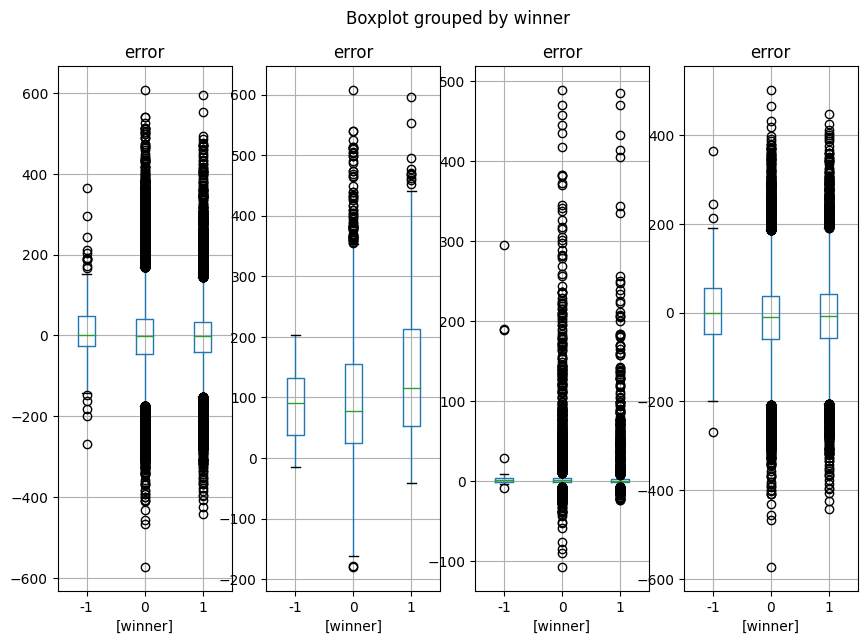

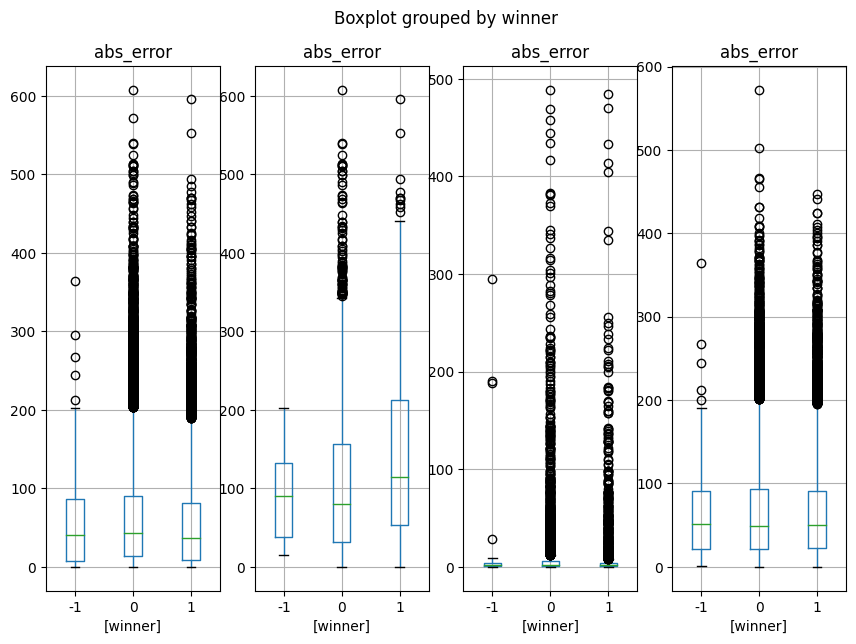

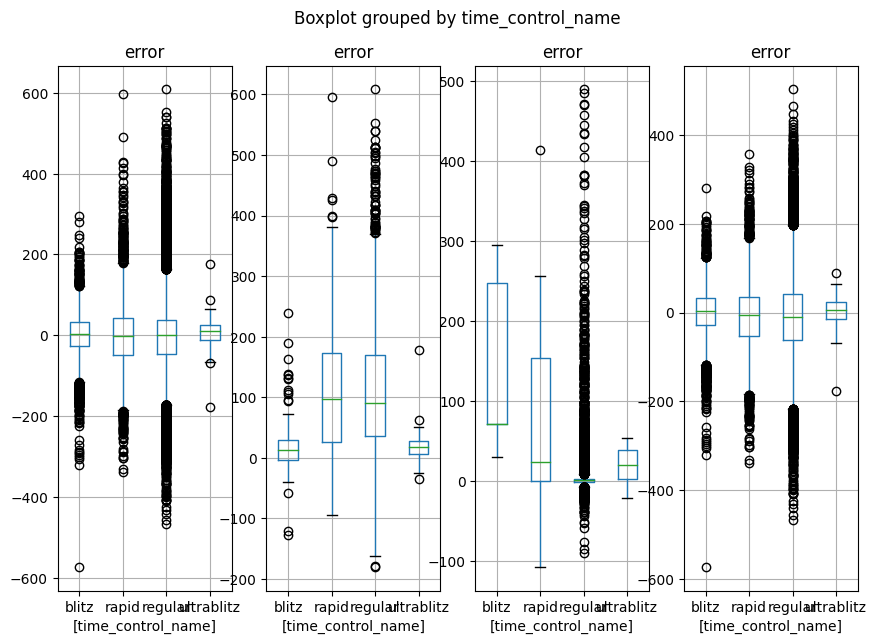

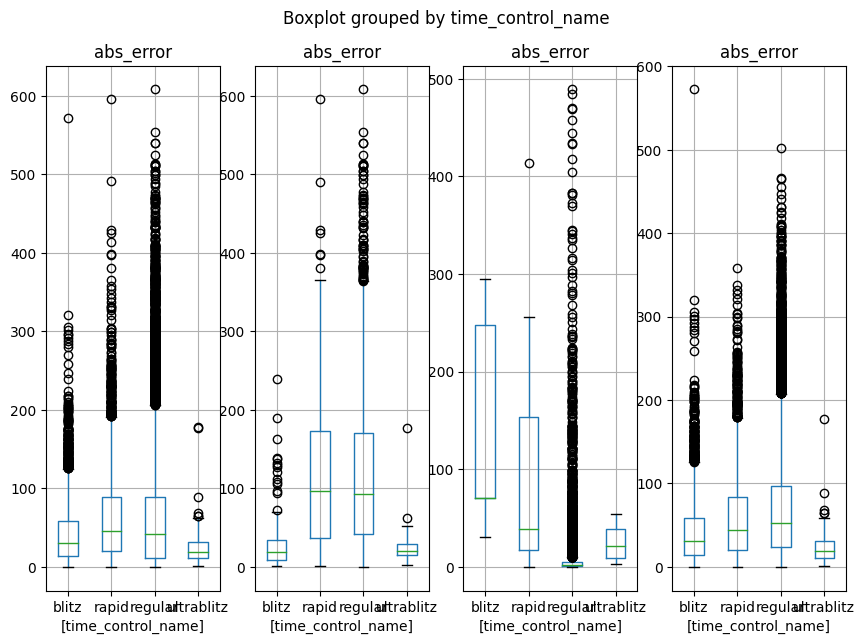

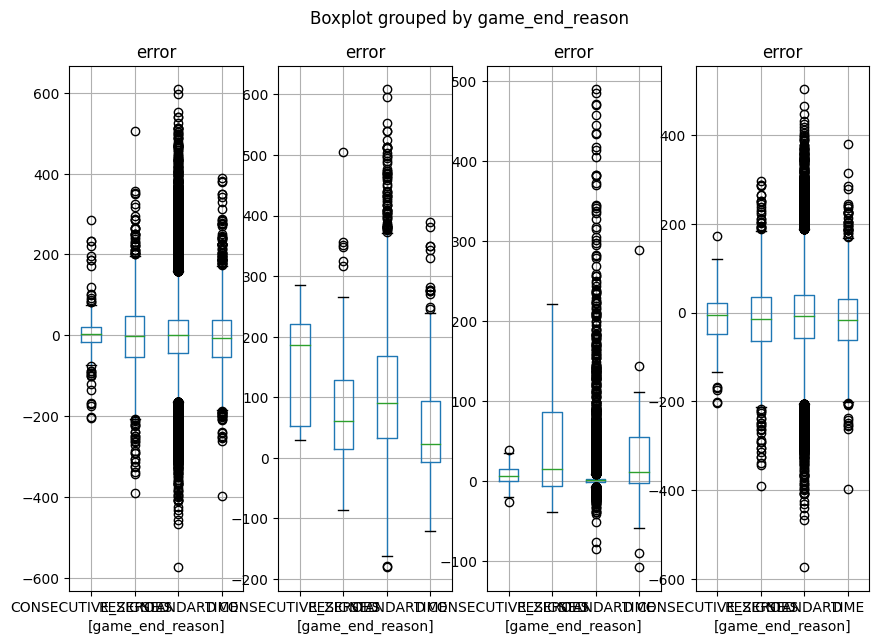

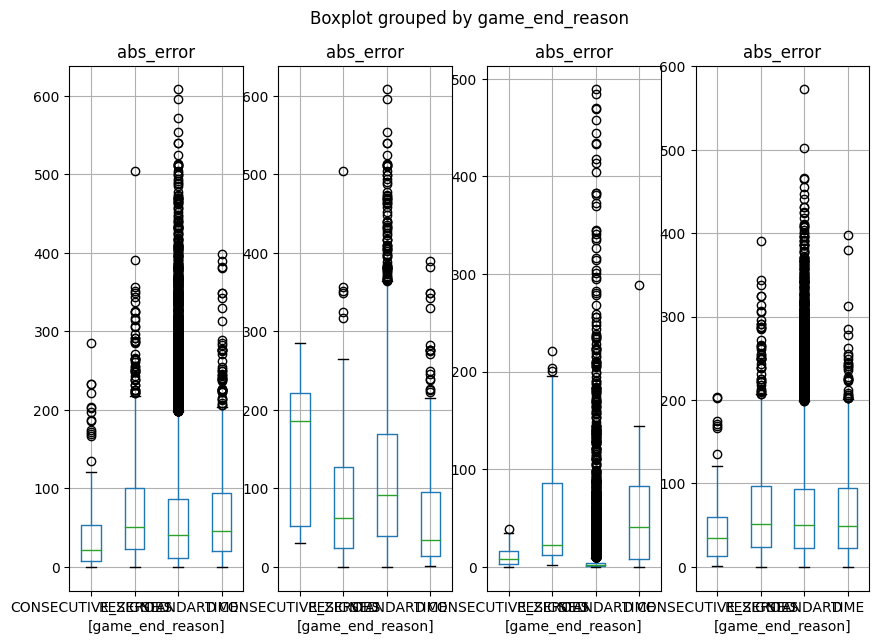

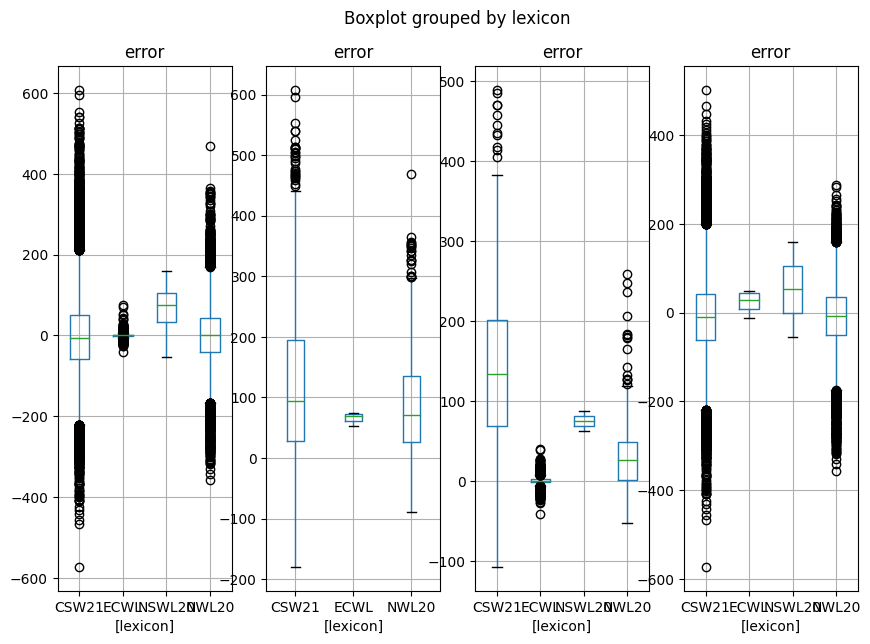

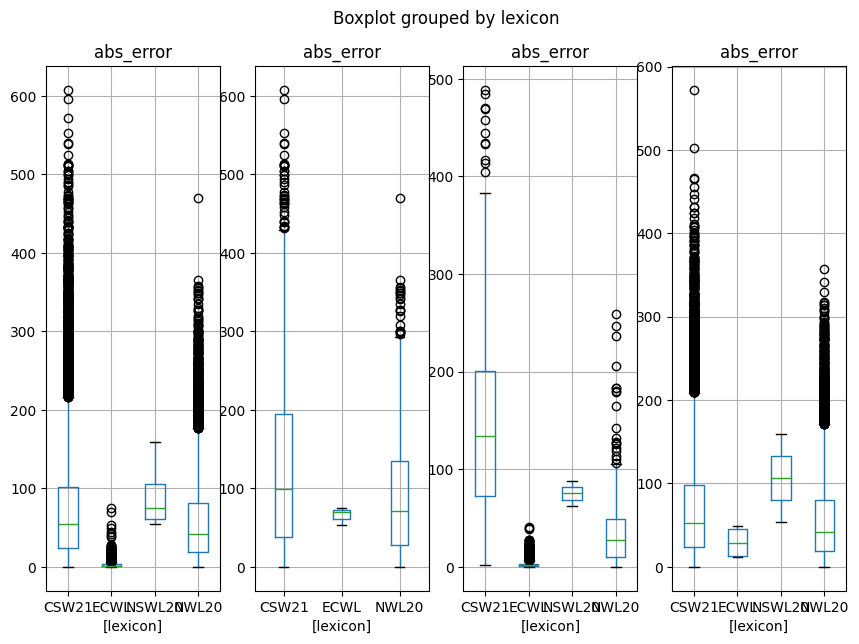

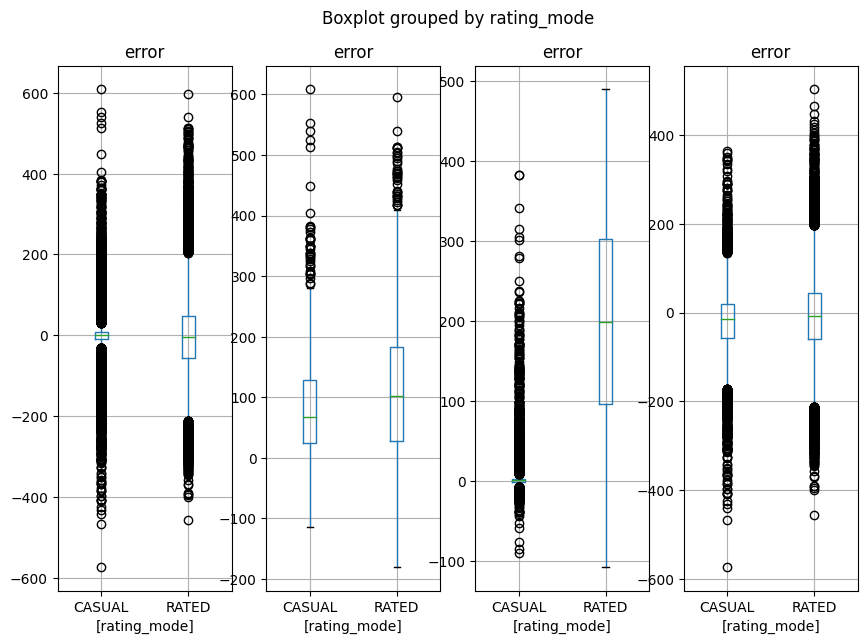

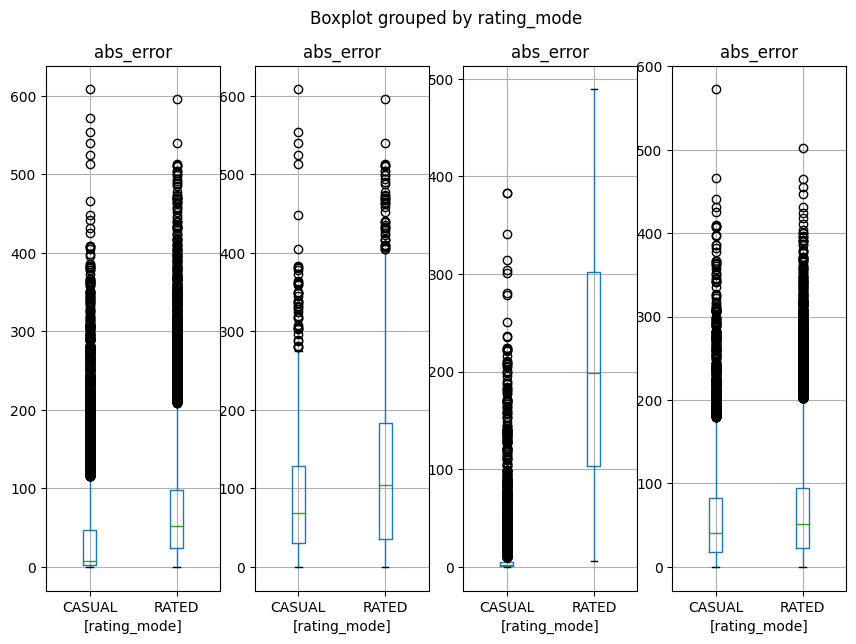

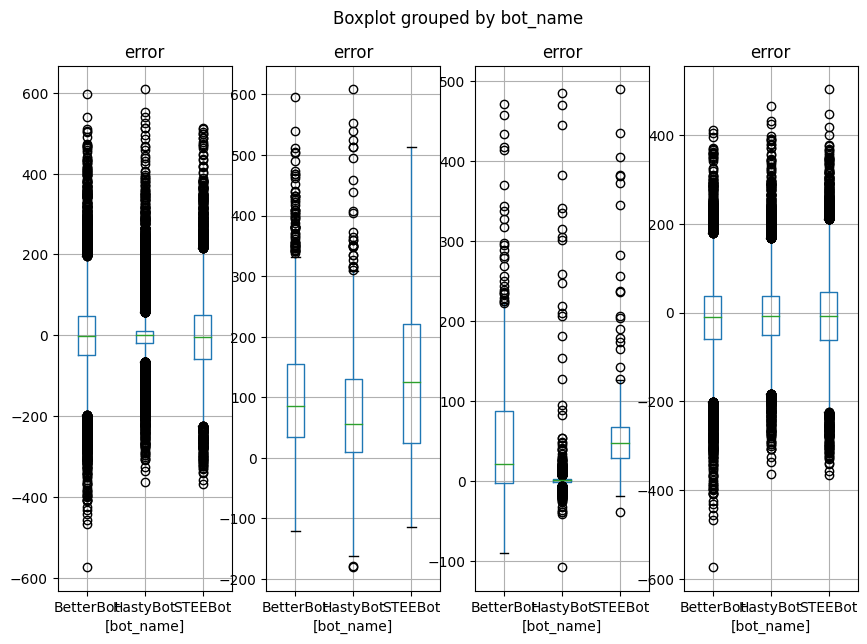

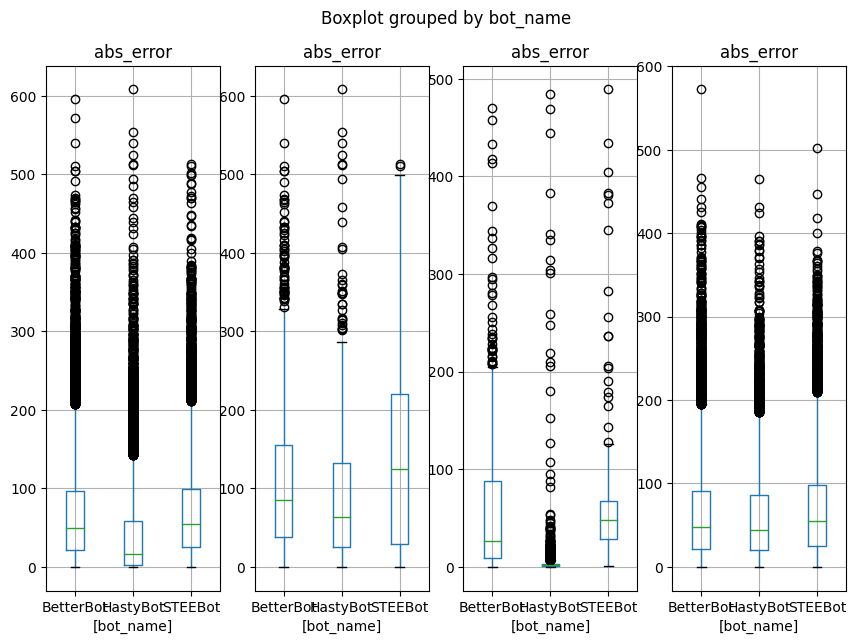

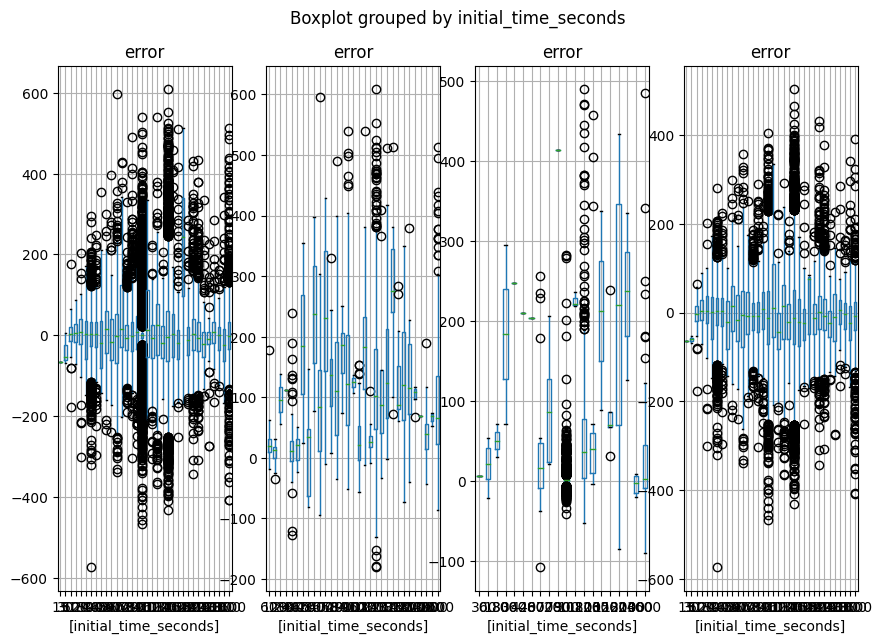

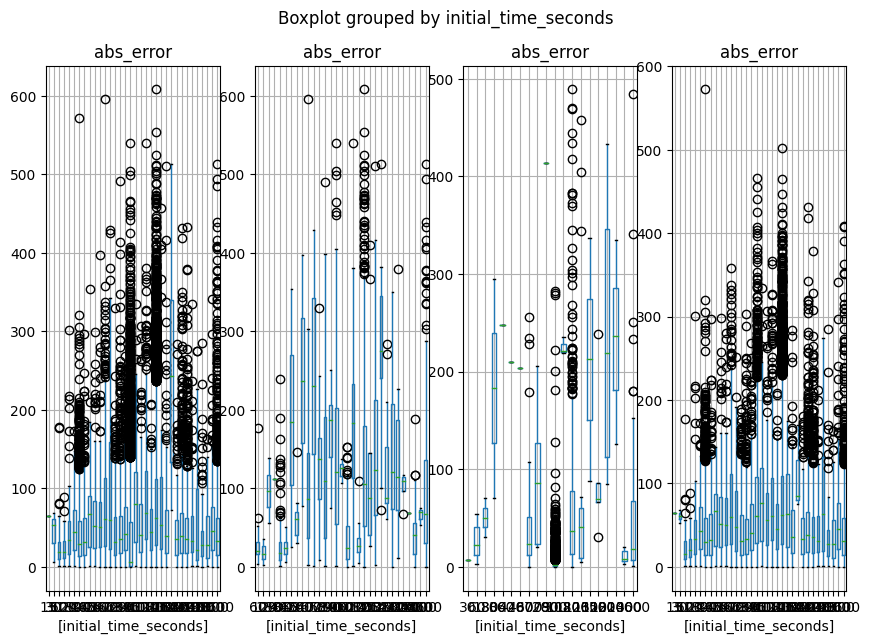

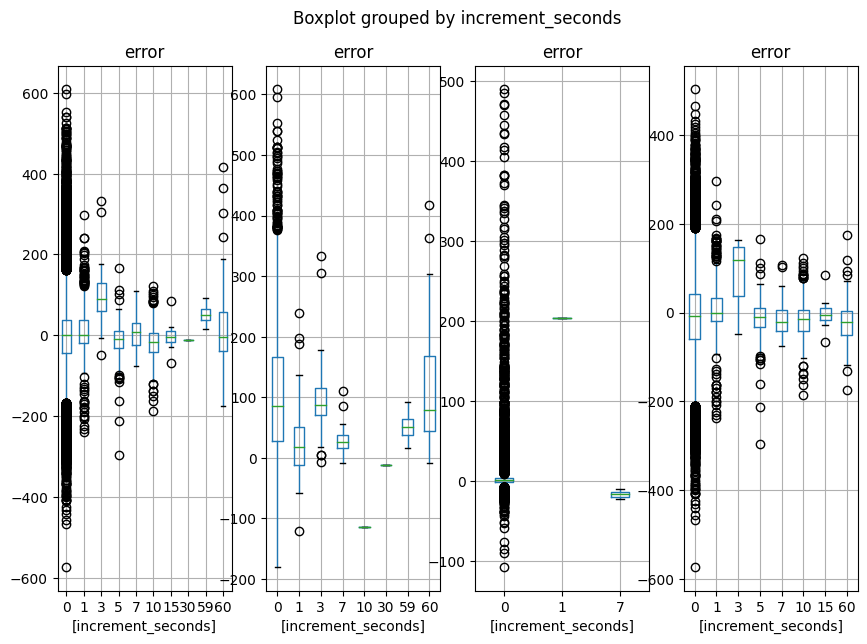

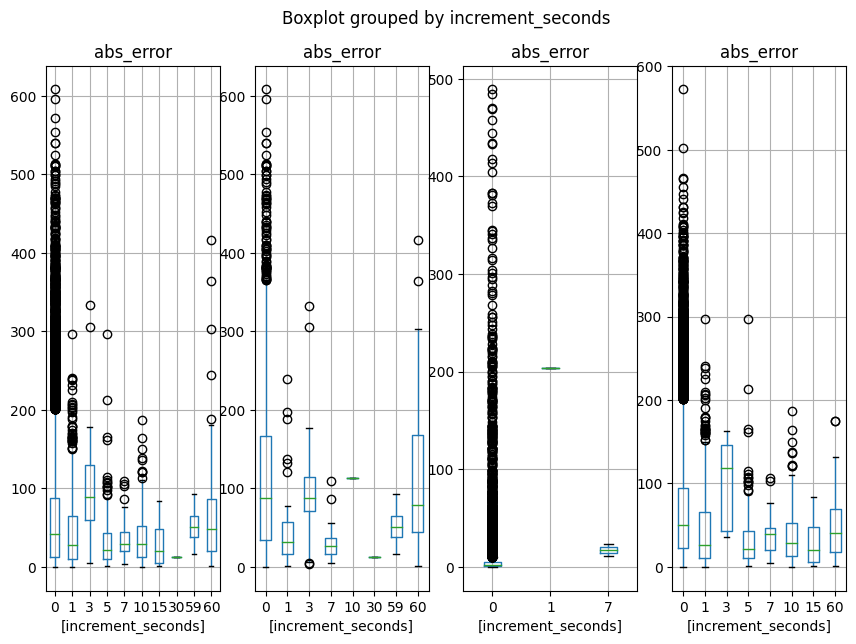

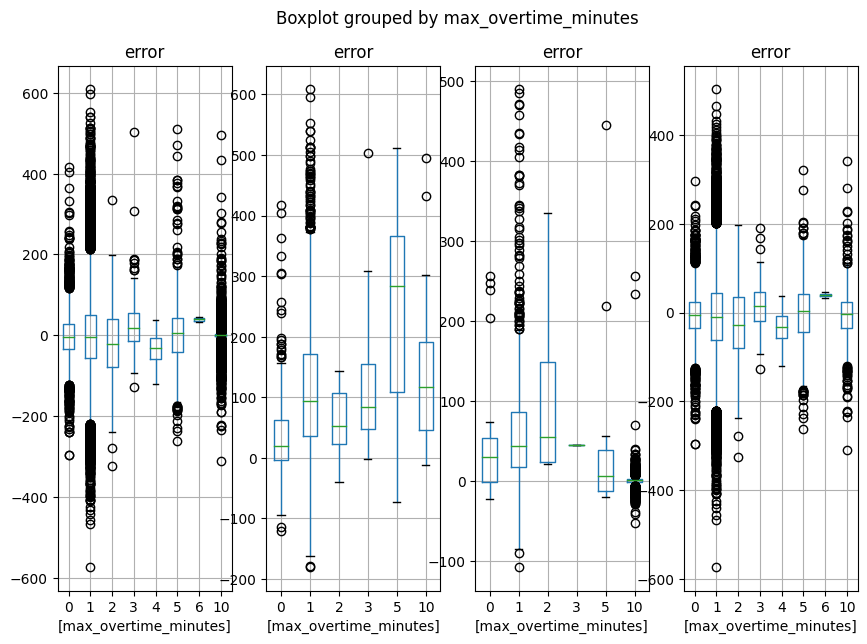

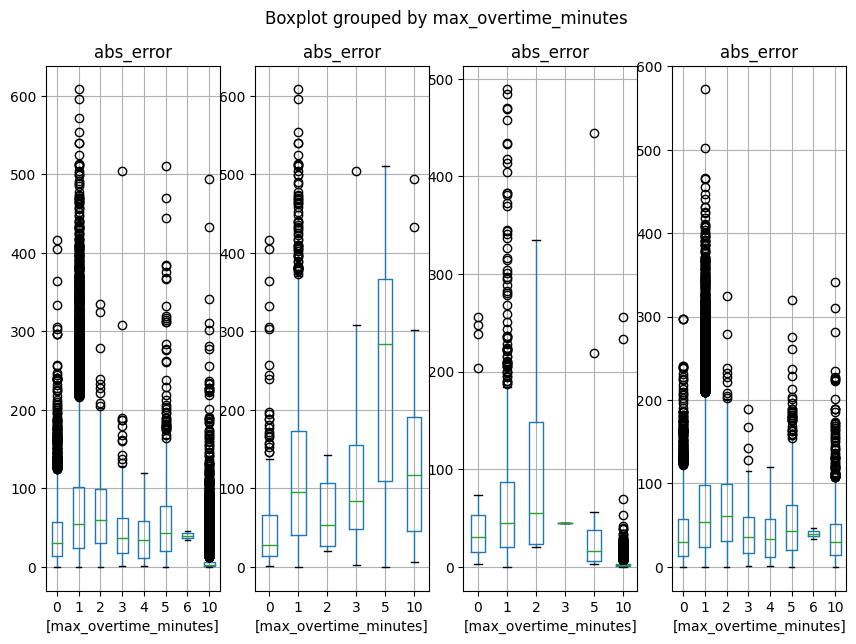

In [137]:
# fig, axes = plt.subplots(len(cats), 3)
more_mask = (data['rating'] > 1500)
less_mask = (data['rating'] < 1500)
both_mask = ~more_mask & ~less_mask

for i, check in enumerate(cats):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
    data[[check, 'error']].boxplot(by=check, ax=axes[0])
    data[less_mask][[check, 'error']].boxplot(by=check, ax=axes[1])
    data[both_mask][[check, 'error']].boxplot(by=check, ax=axes[2])
    data[more_mask][[check, 'error']].boxplot(by=check, ax=axes[3])
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
    data[[check, 'abs_error']].boxplot(by=check, ax=axes[0])
    data[less_mask][[check, 'abs_error']].boxplot(by=check, ax=axes[1])
    data[both_mask][[check, 'abs_error']].boxplot(by=check, ax=axes[2])
    data[more_mask][[check, 'abs_error']].boxplot(by=check, ax=axes[3])

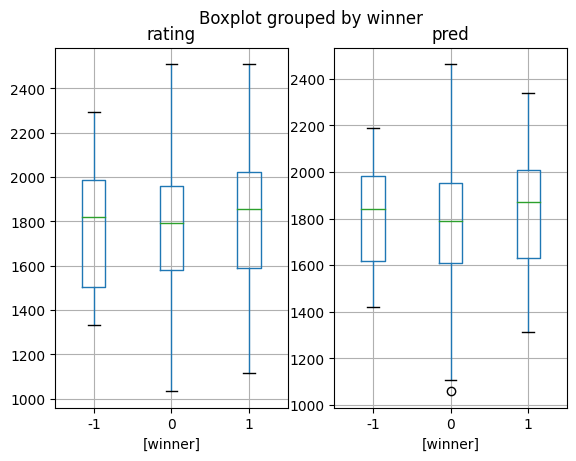

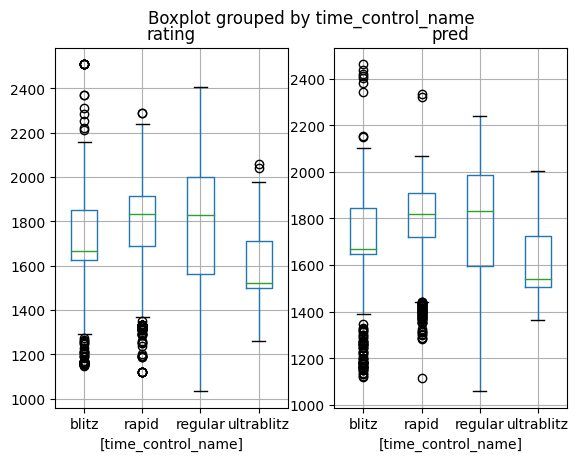

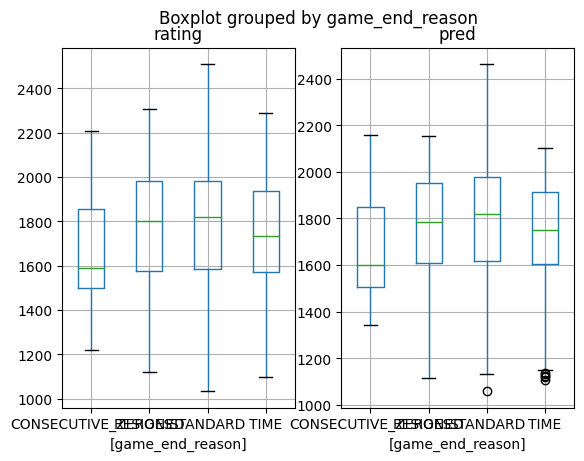

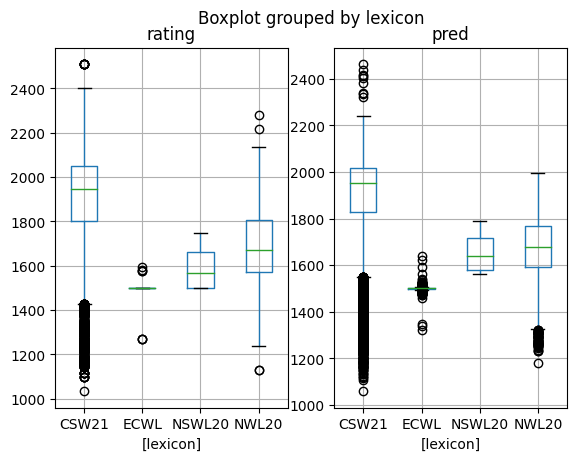

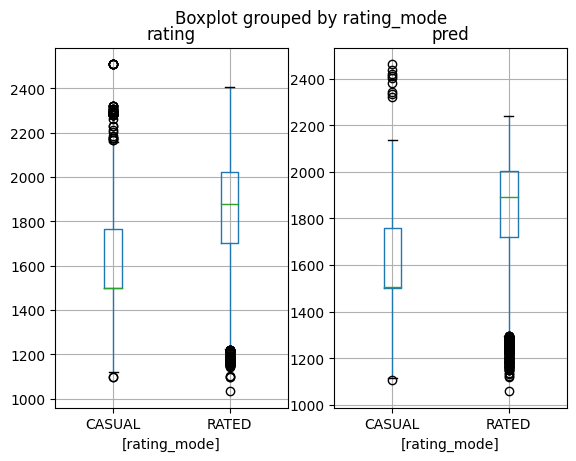

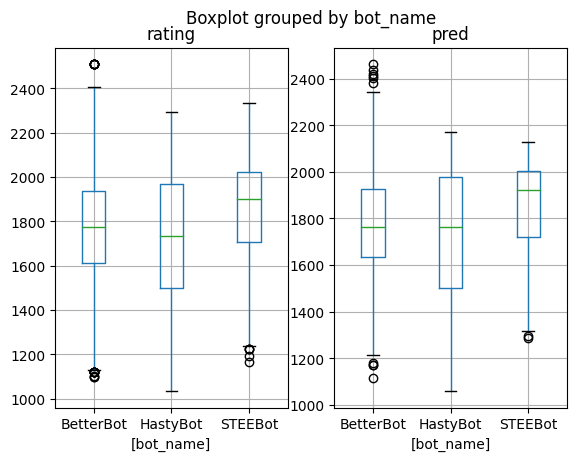

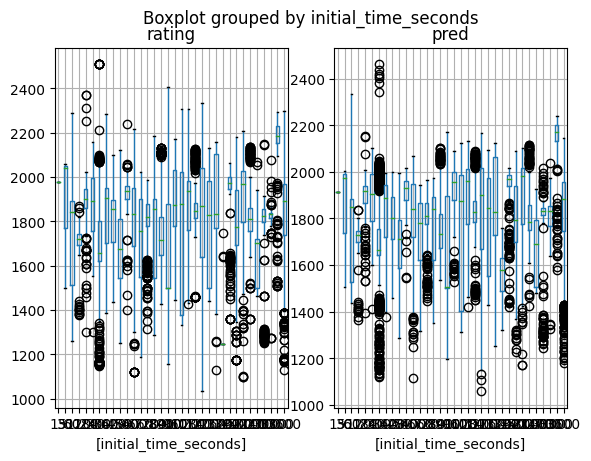

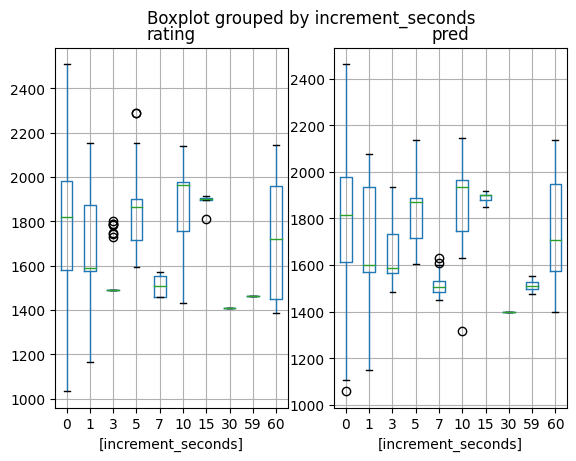

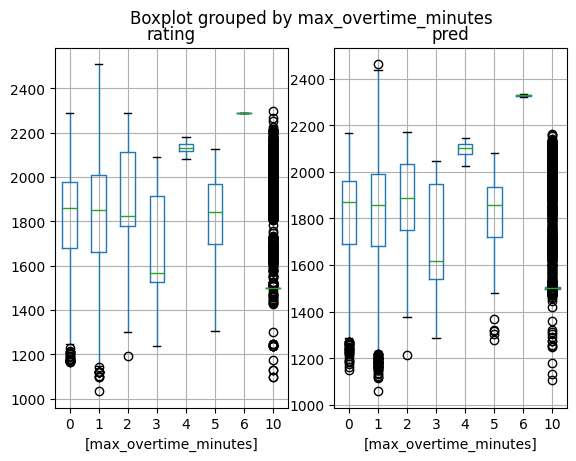

In [ ]:
# fig, axes = plt.subplots(len(cats), 3)
# mask = (data['rating'] < 1600) & (data['rating'] > 1400)
for i, check in enumerate(cats):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    data[[check, 'rating']].boxplot(by=check, ax=axes[0])
    data[[check, 'pred']].boxplot(by=check, ax=axes[1])

In [52]:
print(data[abs_error > 100].shape[0])


10210


In [53]:
print(data.shape[0])
print(data[(error > 200)].shape[0])
print(data[(error > 200) & ~((data['bot_rating'] - data['rating']) > 150)].shape[0])
print(data[(error > 100)].shape[0])
print(data[(error > 100) & ~((data['bot_rating'] - data['rating']) > 150)].shape[0])
print(data[(error > 100) & ~((data['bot_rating'] - data['rating']) > 200)].shape[0])



50410
1192
9
5075
288
642


In [54]:
print(data.shape[0])
print(data[(error < -100)].shape[0])
print(data[(error < -100) & ~(np.abs(data['bot_rating'] - data['rating']) > 100)].shape[0])



50410
5135
2953


In [55]:
features

array(['initial_time_seconds', 'max_overtime_minutes',
       'game_duration_seconds', 'bot_rating',
       'a_turn_type_Challenge__mean', 'a_turn_type_Pass__sum_values',
       'a_turn_type_Timeout__mean', 'a_Z__mean', 'p_points__sum_values',
       'p_points__median', 'p_points__mean', 'p_points__root_mean_square',
       'p_score__root_mean_square', 'p_score__maximum',
       'p_turn_type_End__mean', 'p_turn_type_Exchange__sum_values',
       'p_turn_type_Pass__mean', 'p_turn_type_Pass__standard_deviation',
       'p_turn_type_Play__mean', 'p_A__maximum', 'p_I__maximum',
       'p_.__median', 'p_move_len__mean', 'p_move_len__root_mean_square',
       'p_jokers_num__sum_values', 'p_jokers_num__mean',
       'b_turn_type_End__mean', 'b_e__standard_deviation', 'b_l__mean',
       'b_move_len__sum_values', 'b_jokers_num__mean',
       'time_control_name_blitz', 'time_control_name_rapid',
       'time_control_name_regular', 'lexicon_CSW21', 'rating_mode_CASUAL',
       'bot_name_BetterBo

checking what happens if I do without bot ratings (dbr = drop bot ratings)

In [56]:
dbr_regressor_steps = [('extract_first', ColumnsSetterTransformer({'is_bot_first': IsBotExtarctor(names, name_col='first')})),
                   ('hot', OneHotEncoderTransformer({'time_control_name': games['time_control_name'].unique(),
                                                     'game_end_reason':  games['game_end_reason'].unique(),
                                                     'lexicon':  games['lexicon'].unique(),
                                                     'rating_mode':  games['rating_mode'].unique(),
                                                     'bot_name': names}
                                                        )),
                   ('select_col', SelectTransformer(features)),
                   ('drop_bot', NameDropperTransformer(['bot_rating'])),
                   ('xgb', XGBRegressor(random_state=0,
                                        max_depth=7, min_child_weight=1,
                                        gamma=0,
                                        subsample=1, colsample_bytree=1,
                                        reg_alpha=0.00005, reg_lambda=1,
                                        learning_rate=np.sqrt(3)/10
                                        )),                                              
                   ]

dbr_regressor = Pipeline(dbr_regressor_steps)
dbr_regressor.fit(n_data, n_ratings)

Pipeline(steps=[('extract_first',
                 ColumnsSetterTransformer(columns={'is_bot_first': <functions.is_bot_extractor.IsBotExtarctor object at 0x000002003E97BF40>})),
                ('hot',
                 OneHotEncoderTransformer(columns={'bot_name': ['BetterBot',
                                                                'STEEBot',
                                                                'HastyBot'],
                                                   'game_end_reason': array(['STANDARD', 'RESIGNED', 'TIME', 'CONSECUTIVE_ZEROES'], dtype=object),
                                                   'lexicon': array(['...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.17320508075688773, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...))])

In [57]:
dbr_prediction = pd.Series(dbr_regressor.predict(n_data), index=n_ratings.index)

In [58]:
mean_squared_error(n_ratings, dbr_prediction, squared=False)

88.877530986241

In [59]:
dbr_abs_error = np.abs(dbr_prediction - n_ratings)
dbr_error = dbr_prediction - n_ratings

In [60]:
dbr_data = data.assign(**{'rating': n_ratings, 'dbr_abs_error': dbr_abs_error, 'dbr_pred': dbr_prediction, 'dbr_error': dbr_error})

In [61]:
dbr_data[(error > 100)]['abs_error'].mean()

169.67033251231527

In [62]:
data[error > 100]['abs_error'].mean()

169.67033251231527

In [63]:
(n_ratings == 1500).sum()

7575

In [64]:
print(((n_ratings == 1500)).sum())
print(((abs_error > 100)).sum())
print(((n_ratings == 1500) & (abs_error > 100)).sum())
print(((n_ratings != 1500) & (abs_error > 100)).sum())

7575
10210
179
10031


In [65]:
(abs_error > 100).sum()

10210

<Axes: >

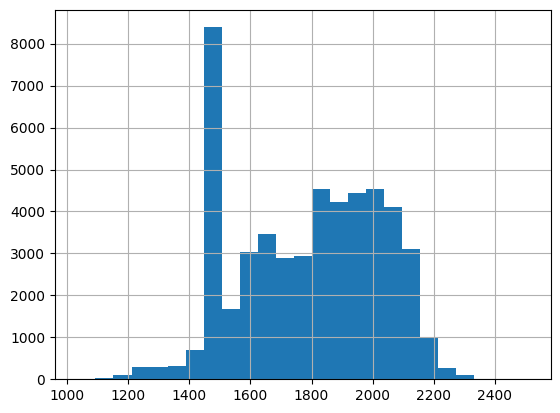

In [66]:
n_ratings.hist(bins=25)

<Axes: >

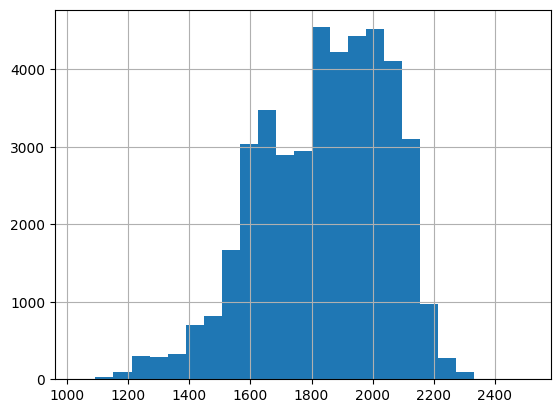

In [67]:
n_ratings[n_ratings != 1500].hist(bins=25)

In [68]:
mean_squared_error(n_ratings[n_ratings != 1500], prediction[n_ratings != 1500], squared=False)

93.13402064441344

In [69]:
abs_error[n_ratings != 1500].mean()

68.48543764579473

try regress without 1500:

In [71]:
regressor_steps = [('extract_first', ColumnsSetterTransformer({'is_bot_first': IsBotExtarctor(names, name_col='first')})),
                   ('hot', OneHotEncoderTransformer({'time_control_name': games['time_control_name'].unique(),
                                                     'game_end_reason':  games['game_end_reason'].unique(),
                                                     'lexicon':  games['lexicon'].unique(),
                                                     'rating_mode':  games['rating_mode'].unique(),
                                                     'bot_name': names}
                                                        )),
                   ('select_col', SelectTransformer(features)),
                   ('xgb', XGBRegressor(random_state=0,
                                        max_depth=7, min_child_weight=1,
                                        gamma=0,
                                        subsample=1, colsample_bytree=1,
                                        reg_alpha=0.00005, reg_lambda=1,
                                        learning_rate=np.sqrt(3)/10
                                        )),                                              
                   ]

no_1500_regressor = Pipeline(regressor_steps)
no_1500_regressor.fit(n_data[n_ratings != 1500], n_ratings[n_ratings != 1500])

Pipeline(steps=[('extract_first',
                 ColumnsSetterTransformer(columns={'is_bot_first': <functions.is_bot_extractor.IsBotExtarctor object at 0x000002003EDD2C70>})),
                ('hot',
                 OneHotEncoderTransformer(columns={'bot_name': ['BetterBot',
                                                                'STEEBot',
                                                                'HastyBot'],
                                                   'game_end_reason': array(['STANDARD', 'RESIGNED', 'TIME', 'CONSECUTIVE_ZEROES'], dtype=object),
                                                   'lexicon': array(['...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.17320508075688773, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...))])

In [72]:
cv_res = cross_validate(no_1500_regressor, n_data[n_ratings != 1500], n_ratings[n_ratings != 1500], cv=5,
                         scoring=('neg_root_mean_squared_error'),
                         return_train_score=True,)

In [73]:
pd.DataFrame(cv_res).mean()


fit_time         4.850845
score_time       0.110246
test_score    -112.649230
train_score    -90.478092
dtype: float64

In [75]:
no_1500_prediction = pd.Series(no_1500_regressor.predict(n_data), index=n_ratings.index)

In [76]:
np.abs(n_ratings[n_ratings != 1500] - no_1500_prediction).mean()

67.95086309282257

In [77]:
mean_squared_error(n_ratings, no_1500_prediction, squared=False)

91.85434327447635

In [78]:
n_ratings[n_ratings != 1500].describe()

count    42835.000000
mean      1841.663733
std        211.023071
min       1033.000000
25%       1682.000000
50%       1865.000000
75%       2008.000000
max       2510.000000
Name: rating, dtype: float64

In [79]:
no_1500_prediction.describe()

count    50410.000000
mean      1798.196411
std        197.554031
min       1070.105957
25%       1628.560181
50%       1815.737854
75%       1977.069885
max       2472.225098
dtype: float64

try predict 1500:

In [80]:
classify_big_abs_error_steps = [('extract_first', ColumnsSetterTransformer({'is_bot_first': IsBotExtarctor(names, name_col='first')})),
                   ('hot', OneHotEncoderTransformer({'time_control_name': games['time_control_name'].unique(),
                                                     'game_end_reason':  games['game_end_reason'].unique(),
                                                     'lexicon':  games['lexicon'].unique(),
                                                     'rating_mode':  games['rating_mode'].unique(),
                                                     'bot_name': names}
                                                        )),
                   ('select_col', SelectTransformer(features)),
                  #  ('drop_bot', NameDropperTransformer(['bot_rating'])),
                   ('xgb', XGBClassifier(random_state=0,
                                        max_depth=7, min_child_weight=1,
                                        gamma=0,
                                        subsample=1, colsample_bytree=1,
                                        reg_alpha=0.00005, reg_lambda=1,
                                        learning_rate=np.sqrt(3)/10
                                        )),                                              
                   ]


my_classifier = Pipeline(classify_big_abs_error_steps)
my_classifier.fit(n_data, n_ratings == 1500)

Pipeline(steps=[('extract_first',
                 ColumnsSetterTransformer(columns={'is_bot_first': <functions.is_bot_extractor.IsBotExtarctor object at 0x000002003EDD2E50>})),
                ('hot',
                 OneHotEncoderTransformer(columns={'bot_name': ['BetterBot',
                                                                'STEEBot',
                                                                'HastyBot'],
                                                   'game_end_reason': array(['STANDARD', 'RESIGNED', 'TIME', 'CONSECUTIVE_ZEROES'], dtype=object),
                                                   'lexicon': array(['...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.17320508075688773, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

In [81]:
c_prediction = pd.Series(my_classifier.predict(n_data), index=n_data.index) == 1

In [82]:
accuracy_score(c_prediction[n_ratings != 1500], n_ratings[n_ratings != 1500] == 1500)

0.999509746702463

In [83]:
cv_res = cross_validate(my_classifier, n_data, n_ratings == 1500, cv=5,
                         scoring=('accuracy', 'precision', 'recall', 'f1'),
                         return_train_score=True,)

In [84]:
pd.DataFrame(cv_res).mean()


fit_time           4.748683
score_time         0.135385
test_accuracy      0.991073
train_accuracy     0.998874
test_precision     0.980707
train_precision    0.998013
test_recall        0.959472
train_recall       0.994488
test_f1            0.969972
train_f1           0.996247
dtype: float64

try combine:

In [85]:
final_prediction = c_prediction * 1500 + (~c_prediction) * no_1500_prediction

In [86]:
no_1500_prediction

game_id
1        1558.135498
3        1974.784058
4        1367.058472
5        1599.165283
6        2020.904663
            ...     
72767    1481.739258
72770    1333.214966
72771    1521.925903
72772    1533.207275
72773    2009.347900
Length: 50410, dtype: float32

In [87]:
mean_squared_error(n_ratings, final_prediction, squared=False)

85.58210886972003

In [88]:
final_prediction_2 = c_prediction * 1500 + (~c_prediction) * prediction

In [89]:
mean_squared_error(n_ratings, final_prediction_2, squared=False)

86.21345144646482

In [90]:
final_prediction_3 = c_prediction * prediction + (~c_prediction) * no_1500_prediction

In [91]:
mean_squared_error(n_ratings, final_prediction_3, squared=False)

86.39155836142925

In [92]:
n_ratings.size

50410

In [93]:
n_ratings[n_ratings==1500].size

7575

In [94]:
7575/50410


0.15026780400714143

CV check that:

In [95]:
new_reg_steps = [('extract_first', ColumnsSetterTransformer({'is_bot_first': IsBotExtarctor(names, name_col='first')})),
                   ('hot', OneHotEncoderTransformer({'time_control_name': games['time_control_name'].unique(),
                                                     'game_end_reason':  games['game_end_reason'].unique(),
                                                     'lexicon':  games['lexicon'].unique(),
                                                     'rating_mode':  games['rating_mode'].unique(),
                                                     'bot_name': names}
                                                        )),
                   ('select_col', SelectTransformer(features)),
                  #  ('drop_bot', NameDropperTransformer(['bot_rating'])),
                   ('reg', RegressionWrapperTransformer(
                                                        classfier=XGBClassifier(random_state=0,
                                                                                max_depth=7, min_child_weight=1,
                                                                                gamma=0,
                                                                                subsample=1, colsample_bytree=1,
                                                                                reg_alpha=0.00005, reg_lambda=1,
                                                                                learning_rate=np.sqrt(3)/10
                                                                                ),
                                                        regressor=XGBRegressor(random_state=0,
                                                                                max_depth=7, min_child_weight=1,
                                                                                gamma=0,
                                                                                subsample=1, colsample_bytree=1,
                                                                                reg_alpha=0.00005, reg_lambda=1,
                                                                                learning_rate=np.sqrt(3)/10
                                                                               ),))                                         
                   ]


new_reg = Pipeline(new_reg_steps)
new_reg.fit(n_data, n_ratings)

Pipeline(steps=[('extract_first',
                 ColumnsSetterTransformer(columns={'is_bot_first': <functions.is_bot_extractor.IsBotExtarctor object at 0x000002003EE0EA60>})),
                ('hot',
                 OneHotEncoderTransformer(columns={'bot_name': ['BetterBot',
                                                                'STEEBot',
                                                                'HastyBot'],
                                                   'game_end_reason': array(['STANDARD', 'RESIGNED', 'TIME', 'CONSECUTIVE_ZEROES'], dtype=object),
                                                   'lexicon': array(['...
                                                                     grow_policy=None,
                                                                     importance_type=None,
                                                                     interaction_constraints=None,
                                                                     learning_rate=0.17320508075688773,
                                                                     max_bin=None,
                                                                     max_cat_threshold=None,
                                                                     max_cat_to_onehot=None,
                                                                     max_delta_step=None,
                                                                     max_depth=7,
                                                                     max_leaves=None,
                                                                     min_child_weight=1,
                                                                     missing=nan,
                                                                     monotone_constraints=None,
                                                                     n_estimators=100,
                                                                     n_jobs=None,
                                                                     num_parallel_tree=None,
                                                                     predictor=None,
                                                                     random_state=0, ...)))])

In [96]:
new_reg.predict(n_data)

array([1500.        , 1974.78405762, 1367.05847168, ..., 1500.        ,
       1533.20727539, 2009.34790039])

In [97]:
new_reg = Pipeline(new_reg_steps)
cv_res = cross_validate(new_reg, n_data, n_ratings, cv=5,
                         scoring=('neg_root_mean_squared_error'),
                         return_train_score=True,)

In [113]:
pd.DataFrame(cv_res).mean()


fit_time         4.815035
score_time       0.021097
test_score    -105.798706
train_score    -85.111647
dtype: float64

In [112]:
new_reg2_steps = [('extract_first', ColumnsSetterTransformer({'is_bot_first': IsBotExtarctor(names, name_col='first')})),
                   ('hot', OneHotEncoderTransformer({'time_control_name': games['time_control_name'].unique(),
                                                     'game_end_reason':  games['game_end_reason'].unique(),
                                                     'lexicon':  games['lexicon'].unique(),
                                                     'rating_mode':  games['rating_mode'].unique(),
                                                     'bot_name': names}
                                                        )),
                   ('select_col', SelectTransformer(features)),
                  #  ('drop_bot', NameDropperTransformer(['bot_rating'])),
                   ('reg', Regression2WrapperTransformer(
                                                        classfier=XGBClassifier(random_state=0,
                                                                                max_depth=7, min_child_weight=1,
                                                                                gamma=0,
                                                                                subsample=1, colsample_bytree=1,
                                                                                reg_alpha=0.00005, reg_lambda=1,
                                                                                learning_rate=np.sqrt(3)/10
                                                                                ),
                                                        regressor1=XGBRegressor(random_state=0,
                                                                                max_depth=7, min_child_weight=1,
                                                                                gamma=0,
                                                                                subsample=1, colsample_bytree=1,
                                                                                reg_alpha=0.00005, reg_lambda=1,
                                                                                learning_rate=np.sqrt(3)/10
                                                                               ),
                                                        regressor2=XGBRegressor(random_state=0,
                                                                                max_depth=7, min_child_weight=1,
                                                                                gamma=0,
                                                                                subsample=1, colsample_bytree=1,
                                                                                reg_alpha=0.00005, reg_lambda=1,
                                                                                learning_rate=np.sqrt(3)/10
                                                                               ),
                                                                               ))                                         
                   ]


new_reg2 = Pipeline(new_reg2_steps)
new_reg2.fit(n_data, n_ratings)

Pipeline(steps=[('extract_first',
                 ColumnsSetterTransformer(columns={'is_bot_first': <functions.is_bot_extractor.IsBotExtarctor object at 0x000002003EDD2370>})),
                ('hot',
                 OneHotEncoderTransformer(columns={'bot_name': ['BetterBot',
                                                                'STEEBot',
                                                                'HastyBot'],
                                                   'game_end_reason': array(['STANDARD', 'RESIGNED', 'TIME', 'CONSECUTIVE_ZEROES'], dtype=object),
                                                   'lexicon': array(['...
                                                                       grow_policy=None,
                                                                       importance_type=None,
                                                                       interaction_constraints=None,
                                                                       learning_rate=0.17320508075688773,
                                                                       max_bin=None,
                                                                       max_cat_threshold=None,
                                                                       max_cat_to_onehot=None,
                                                                       max_delta_step=None,
                                                                       max_depth=7,
                                                                       max_leaves=None,
                                                                       min_child_weight=1,
                                                                       missing=nan,
                                                                       monotone_constraints=None,
                                                                       n_estimators=100,
                                                                       n_jobs=None,
                                                                       num_parallel_tree=None,
                                                                       predictor=None,
                                                                       random_state=0, ...)))])

In [114]:
new_reg2.predict(n_data)

array([1507.424 , 1974.784 , 1367.0585, ..., 1502.0891, 1533.2073,
       2009.3479], dtype=float32)

In [116]:
new_reg2 = Pipeline(new_reg2_steps)
cv_res = cross_validate(new_reg2, n_data, n_ratings, cv=5,
                         scoring=('neg_root_mean_squared_error'),
                         return_train_score=True,)

In [117]:
pd.DataFrame(cv_res).mean()


fit_time        13.956834
score_time       0.148628
test_score    -105.903389
train_score    -84.466893
dtype: float64

try look at extreme values:

In [135]:
print(data[abs_error>200].shape)
print(data[(abs_error>300)&~((data['bot_rating'] - data['rating']) > 150)].shape)

(1936, 17)
(96, 17)


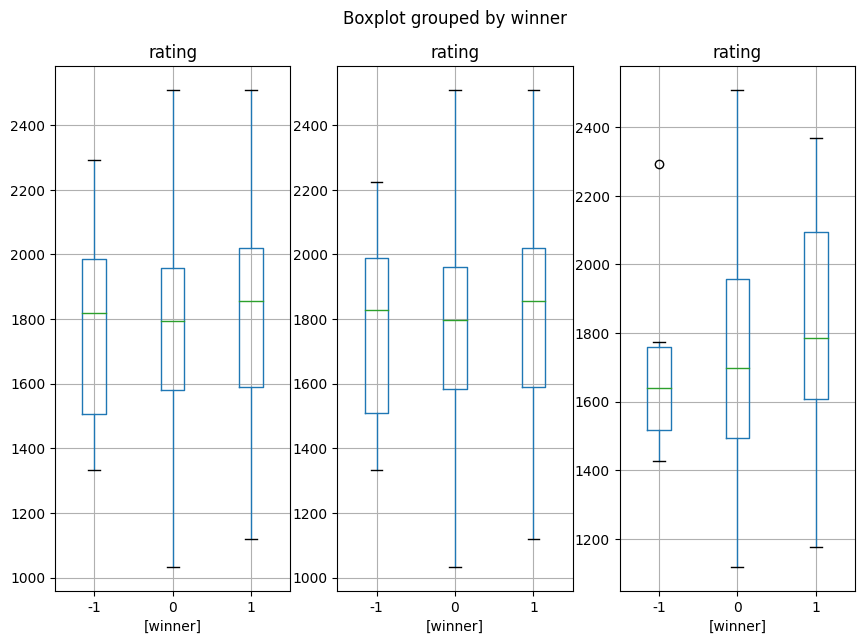

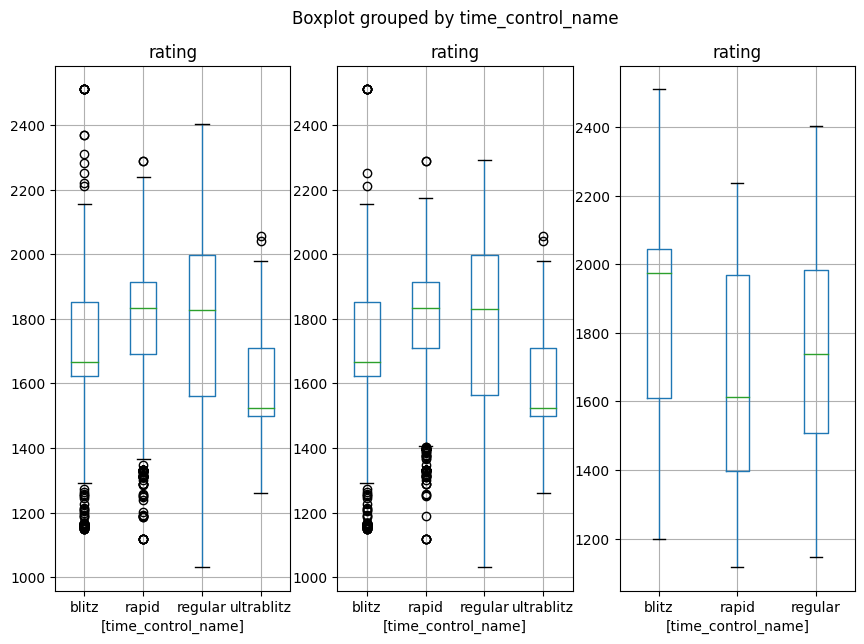

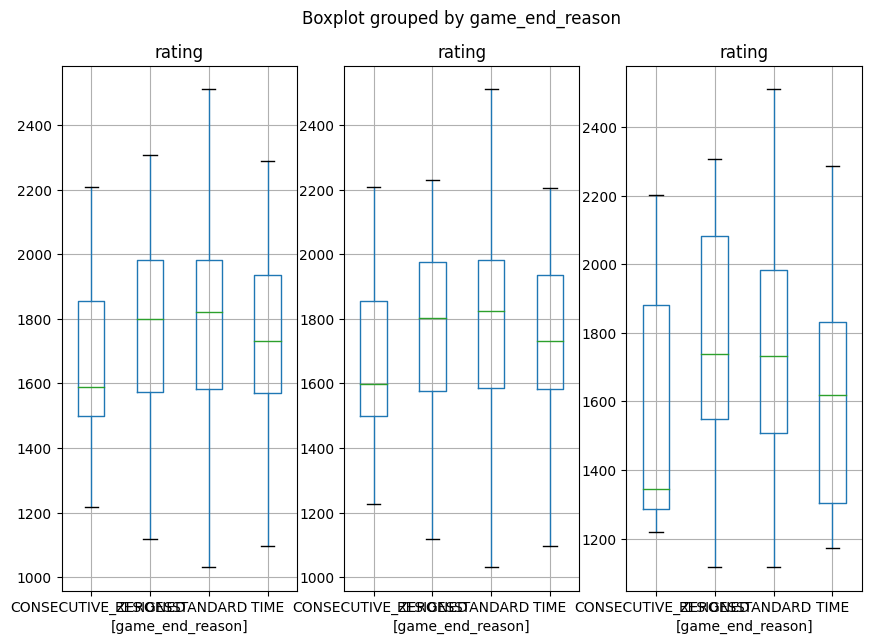

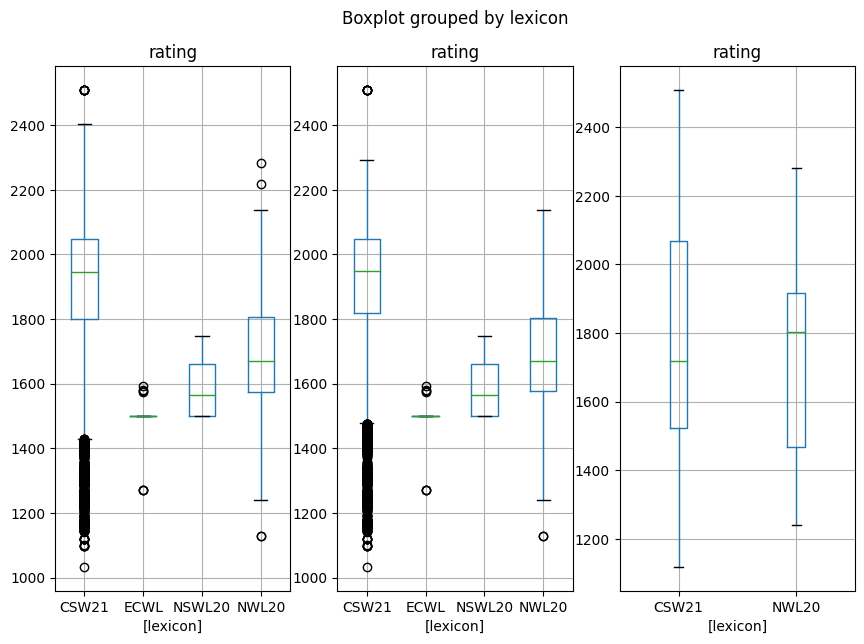

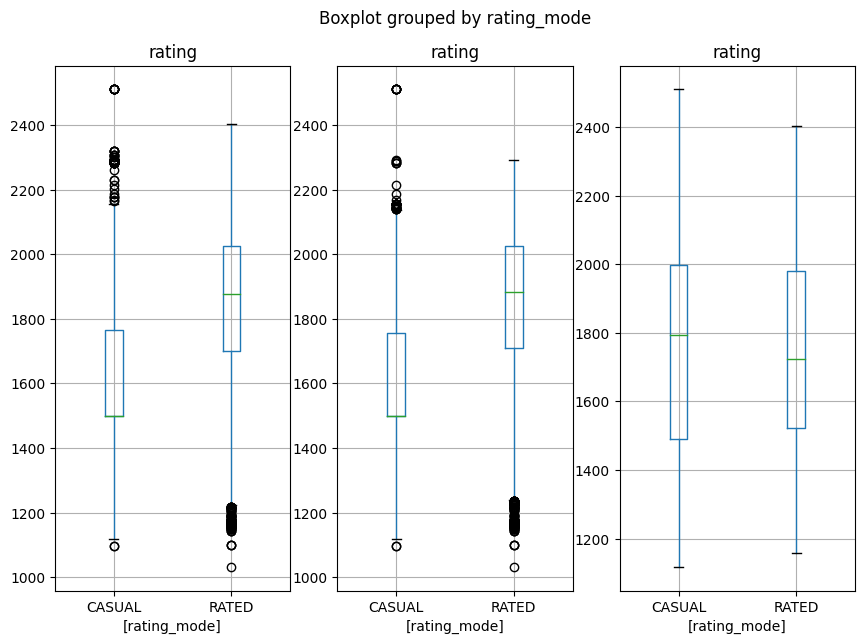

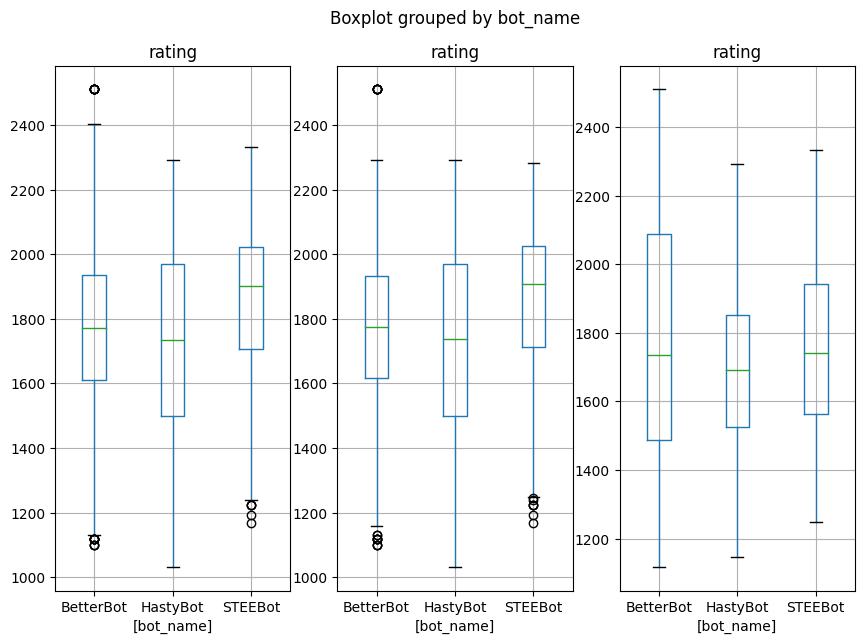

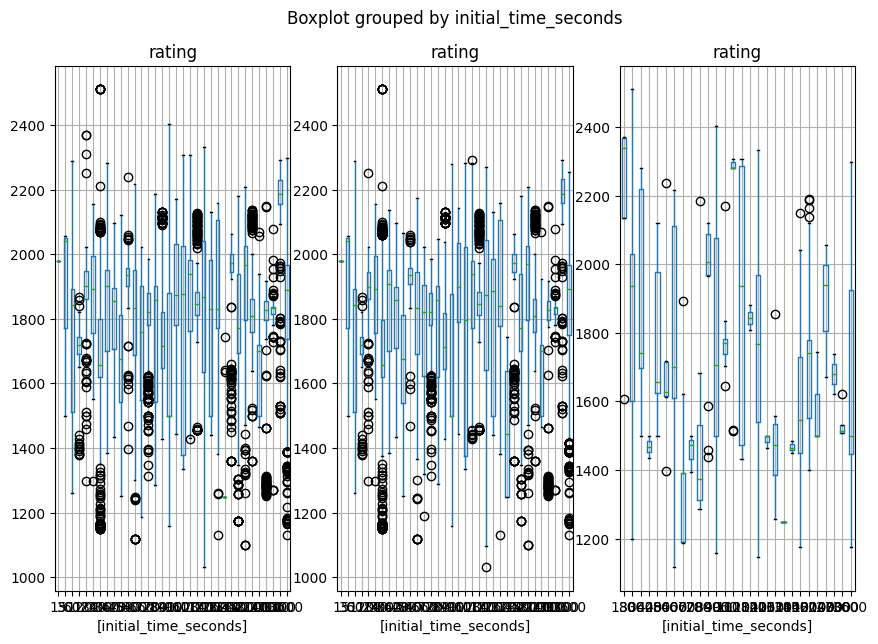

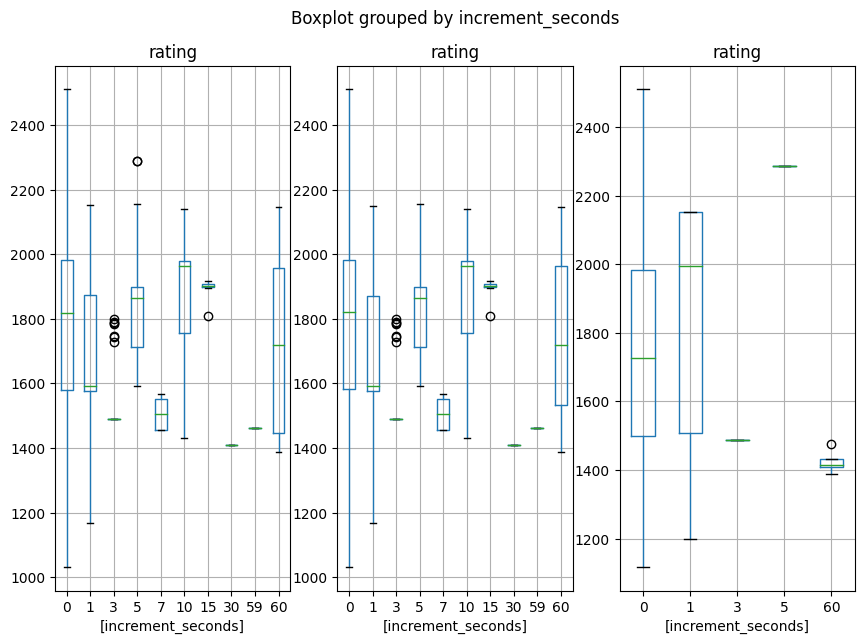

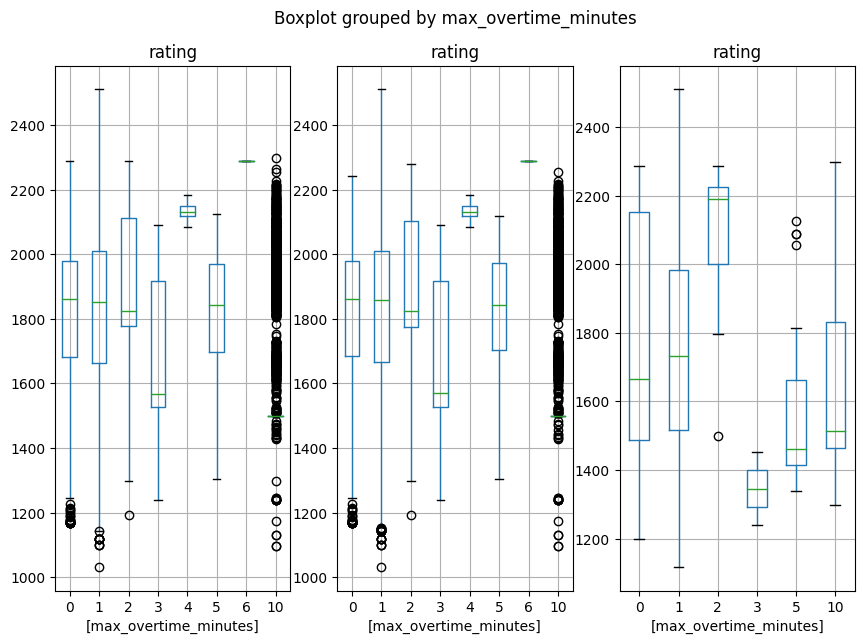

In [138]:
# fig, axes = plt.subplots(len(cats), 3)
more_mask = (abs_error>200)
less_mask = ~more_mask

for i, check in enumerate(cats):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 7))
    data[[check, 'rating']].boxplot(by=check, ax=axes[0])
    data[less_mask][[check, 'rating']].boxplot(by=check, ax=axes[1])
    data[more_mask][[check, 'rating']].boxplot(by=check, ax=axes[2])

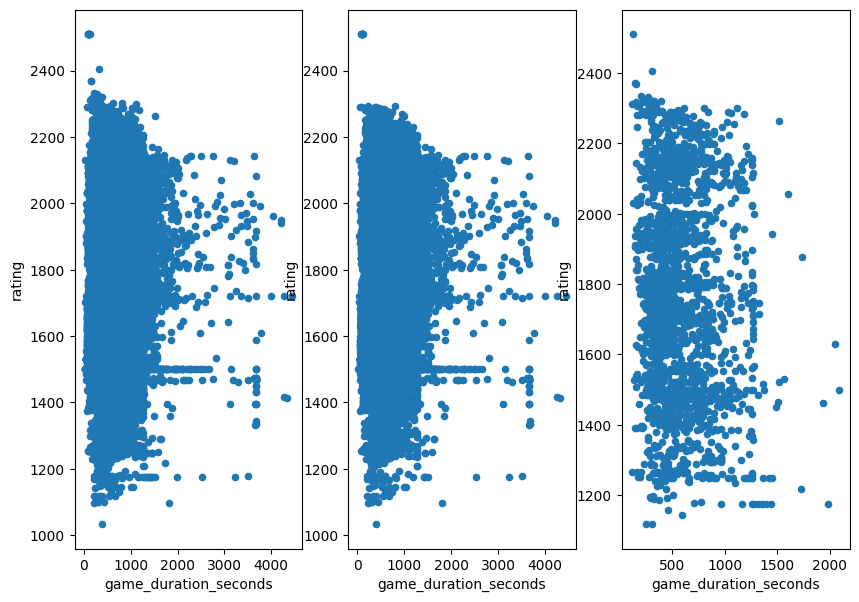

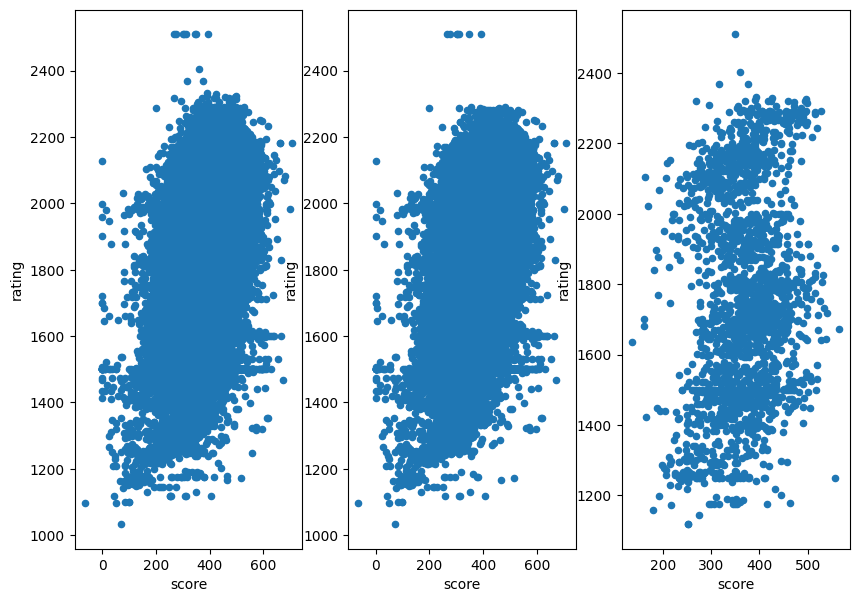

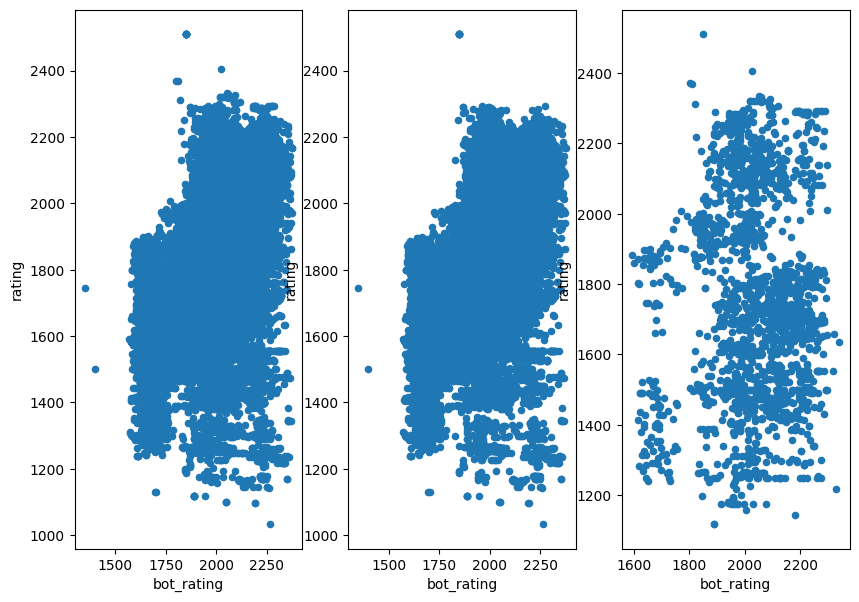

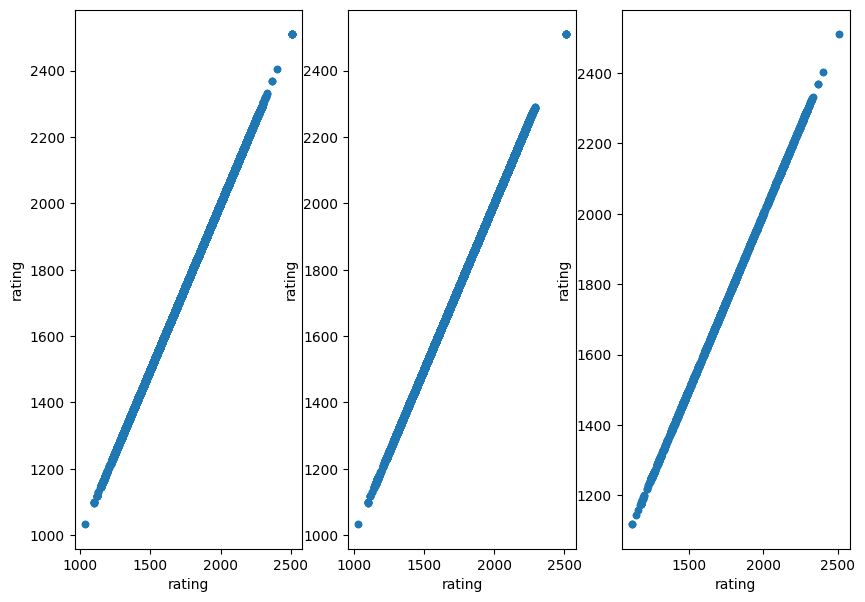

In [14]:
numerical = ['game_duration_seconds', 'score', 'bot_rating', 'rating']
more_mask = (abs_error>200)
less_mask = ~more_mask

for i, check in enumerate(numerical):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 7))
    data[[check, 'rating']].plot.scatter(x=check, y='rating', ax=axes[0])
    data[less_mask][[check, 'rating']].plot.scatter(x=check, y='rating', ax=axes[1])
    data[more_mask][[check, 'rating']].plot.scatter(x=check, y='rating', ax=axes[2])

again with val

In [21]:
X_train, X_val, y_train, y_val = train_test_split(n_data, n_ratings, test_size=0.1, random_state=42)


In [24]:
v_regressor = Pipeline(regressor_steps)
v_regressor.fit(X_train, y_train)

Pipeline(steps=[('extract_first',
                 ColumnsSetterTransformer(columns={'is_bot_first': <functions.is_bot_extractor.IsBotExtarctor object at 0x0000025B3DACEAC0>})),
                ('hot',
                 OneHotEncoderTransformer(columns={'bot_name': ['BetterBot',
                                                                'STEEBot',
                                                                'HastyBot'],
                                                   'game_end_reason': array(['STANDARD', 'RESIGNED', 'TIME', 'CONSECUTIVE_ZEROES'], dtype=object),
                                                   'lexicon': array(['...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.17320508075688773, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...))])

In [26]:
v_prediction = pd.Series(v_regressor.predict(X_val), index=y_val.index)

In [27]:
mean_squared_error(y_val, v_prediction, squared=False)

103.94393526479323

In [30]:
v_abs_error = np.abs(v_prediction - y_val)
v_error = v_prediction - y_val

In [31]:
v_abs_error.describe()

count    5041.000000
mean       71.219197
std        75.718591
min         0.008789
25%        14.352173
50%        48.638916
75%       104.376953
max       663.963379
dtype: float64

In [32]:
v_prediction.describe()

count    5041.000000
mean     1793.764771
std       201.282959
min      1162.762451
25%      1624.190796
50%      1825.881226
75%      1972.643433
max      2243.635010
dtype: float64

In [34]:
y_val.describe()

count    5041.000000
mean     1794.989089
std       231.589869
min      1142.000000
25%      1586.000000
50%      1823.000000
75%      1990.000000
max      2306.000000
Name: rating, dtype: float64

<Axes: >

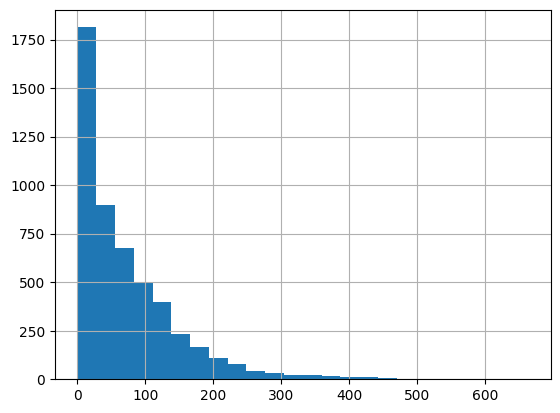

In [35]:
v_abs_error.hist(bins=24)

In [41]:
v_data = n_games.loc[X_val.index].assign(**{'rating': y_val, 'abs_error': v_abs_error, 'pred': v_prediction, 'error': v_error})

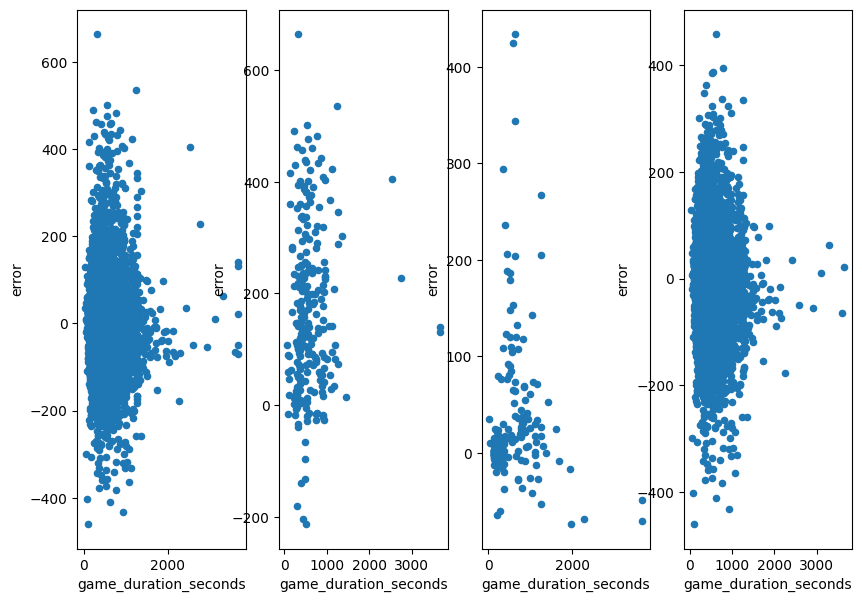

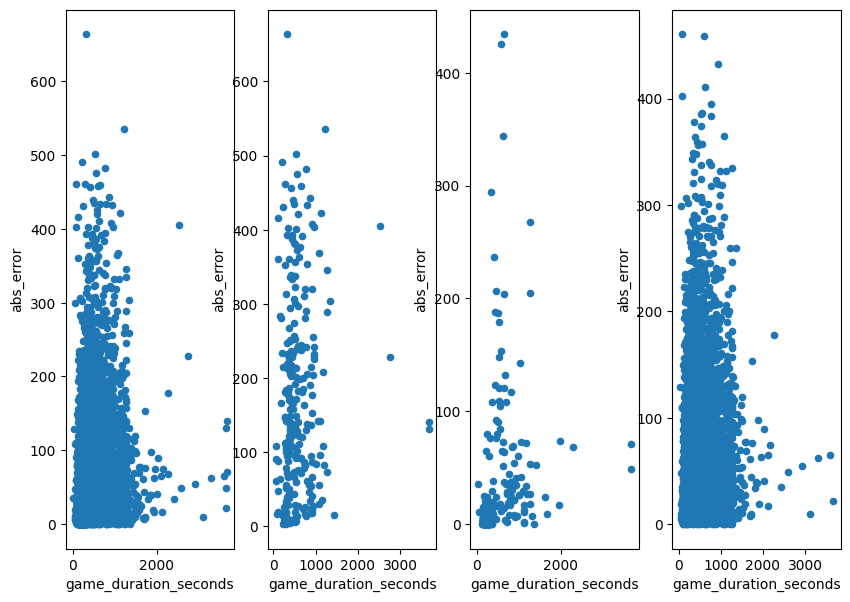

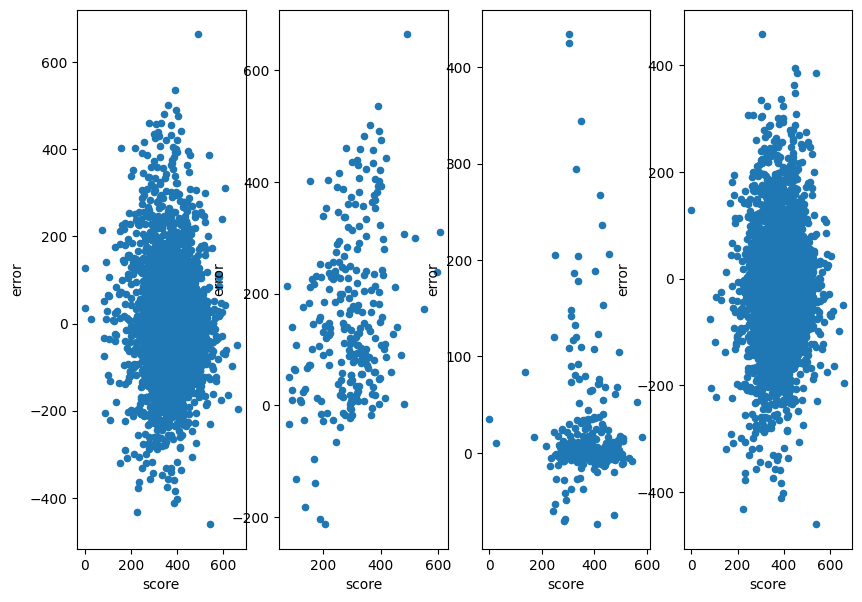

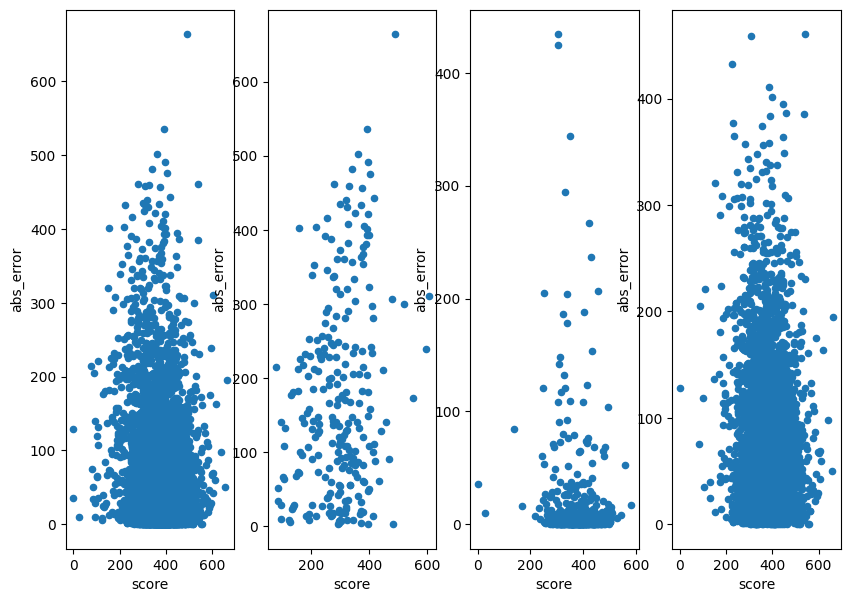

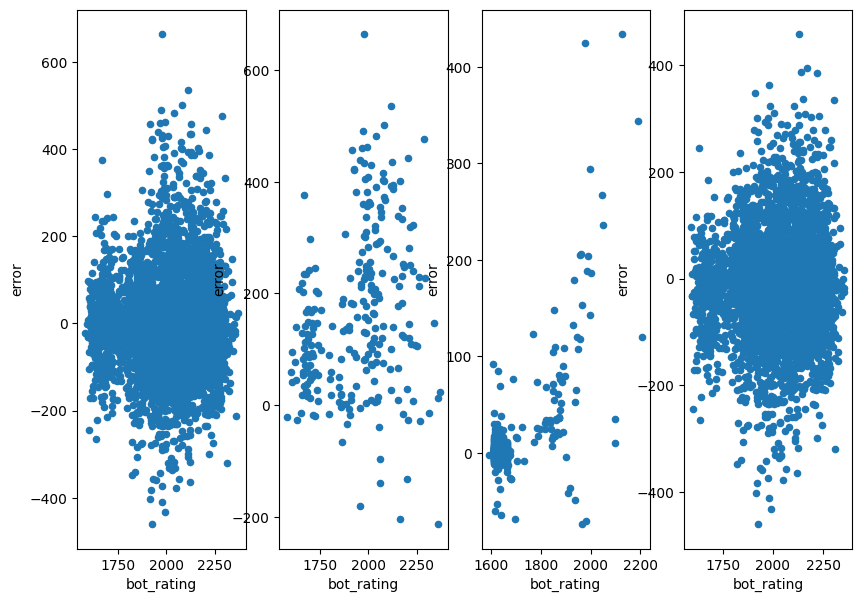

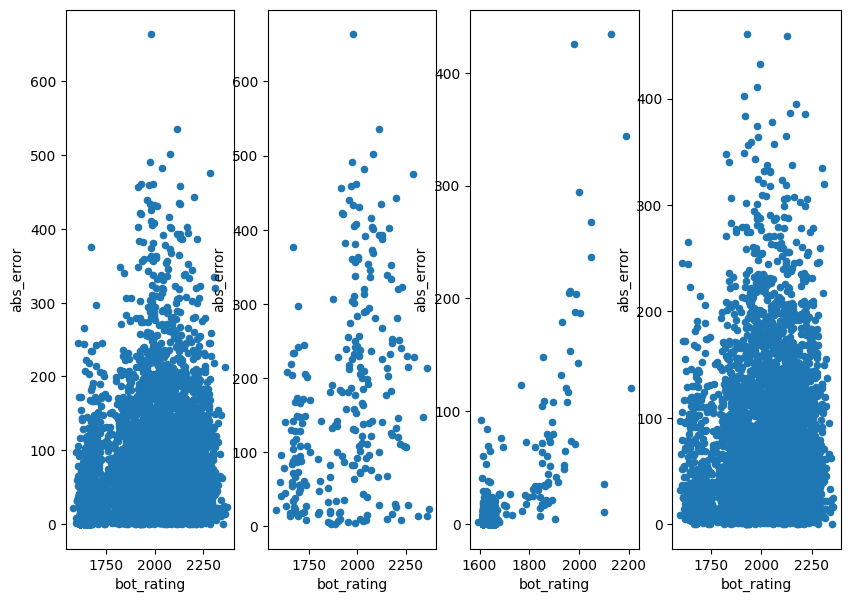

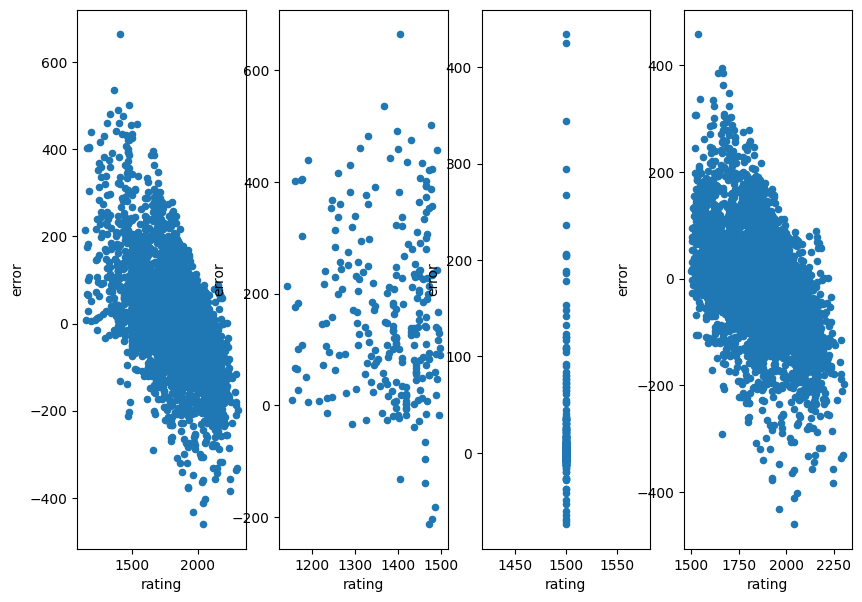

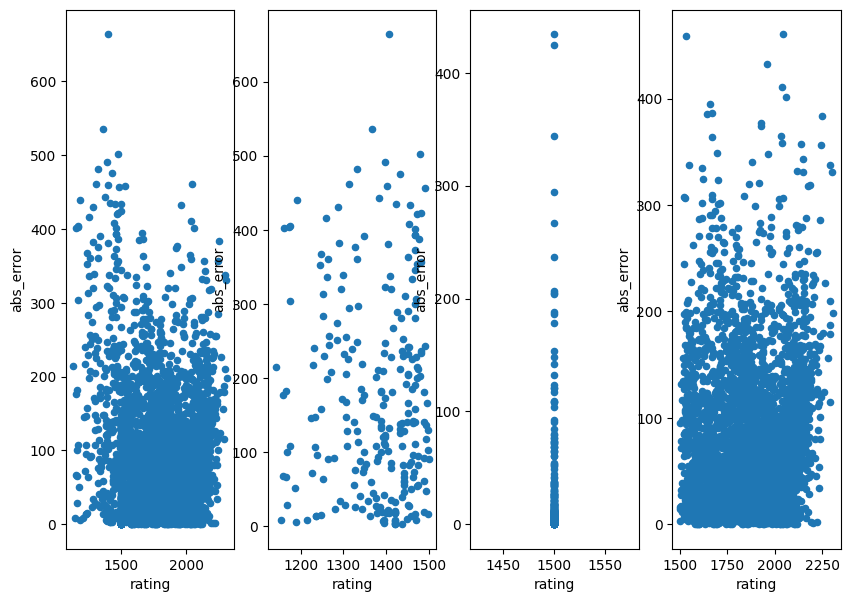

In [43]:
numerical = ['game_duration_seconds', 'score', 'bot_rating', 'rating']
more_mask = (v_data['rating'] > 1500)
less_mask = (v_data['rating'] < 1500)
both_mask = ~more_mask & ~less_mask

for i, check in enumerate(numerical):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
    v_data[[check, 'error']].plot.scatter(x=check, y='error', ax=axes[0])
    v_data[less_mask][[check, 'error']].plot.scatter(x=check, y='error', ax=axes[1])
    v_data[both_mask][[check, 'error']].plot.scatter(x=check, y='error', ax=axes[2])
    v_data[more_mask][[check, 'error']].plot.scatter(x=check, y='error', ax=axes[3])
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
    v_data[[check, 'abs_error']].plot.scatter(x=check, y='abs_error', ax=axes[0])
    v_data[less_mask][[check, 'abs_error']].plot.scatter(x=check, y='abs_error', ax=axes[1])
    v_data[both_mask][[check, 'abs_error']].plot.scatter(x=check, y='abs_error', ax=axes[2])
    v_data[more_mask][[check, 'abs_error']].plot.scatter(x=check, y='abs_error', ax=axes[3])

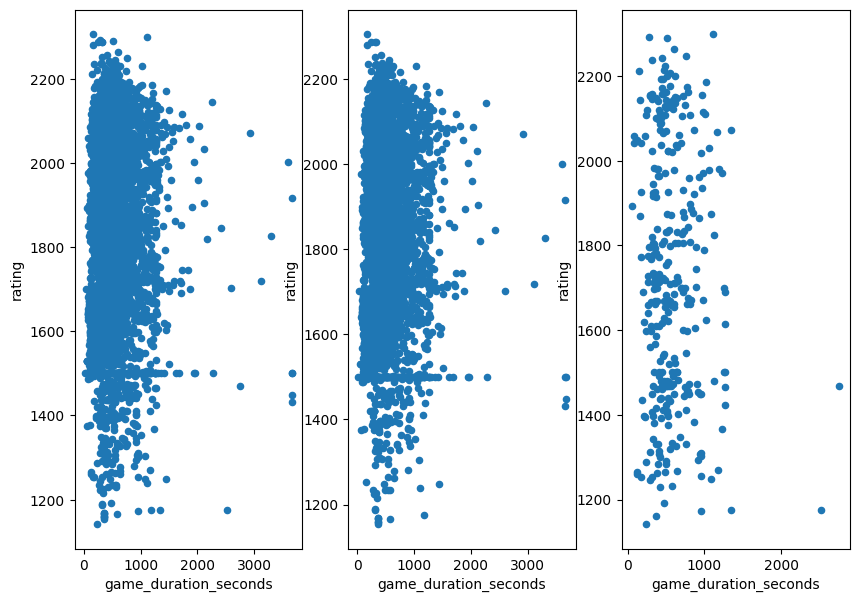

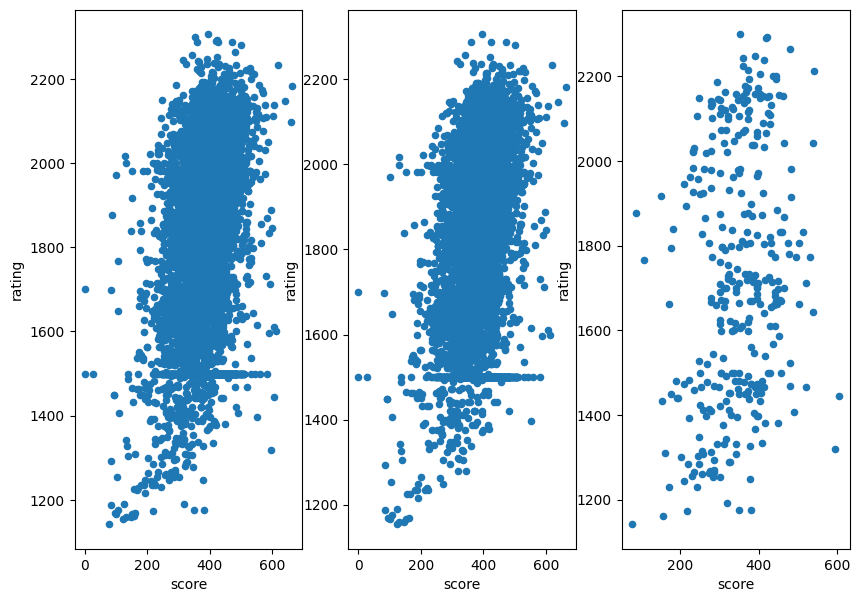

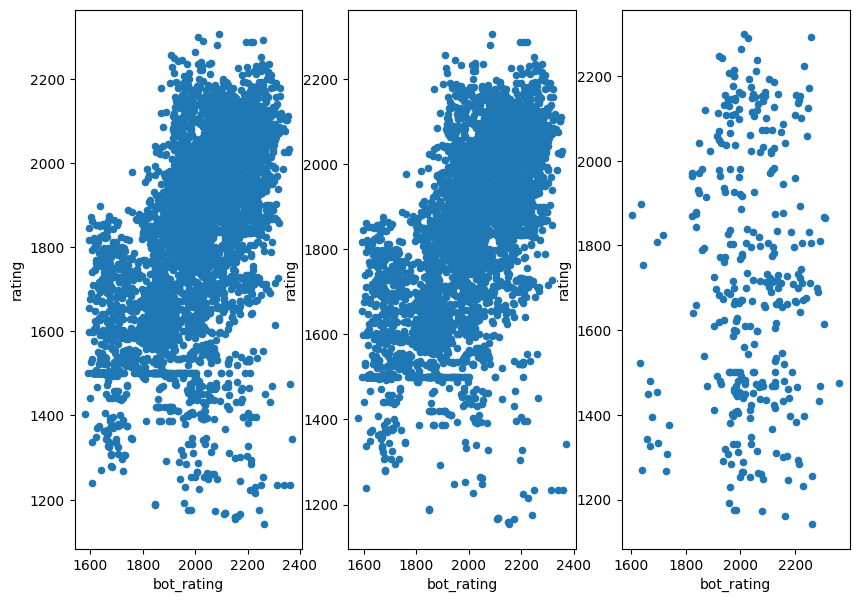

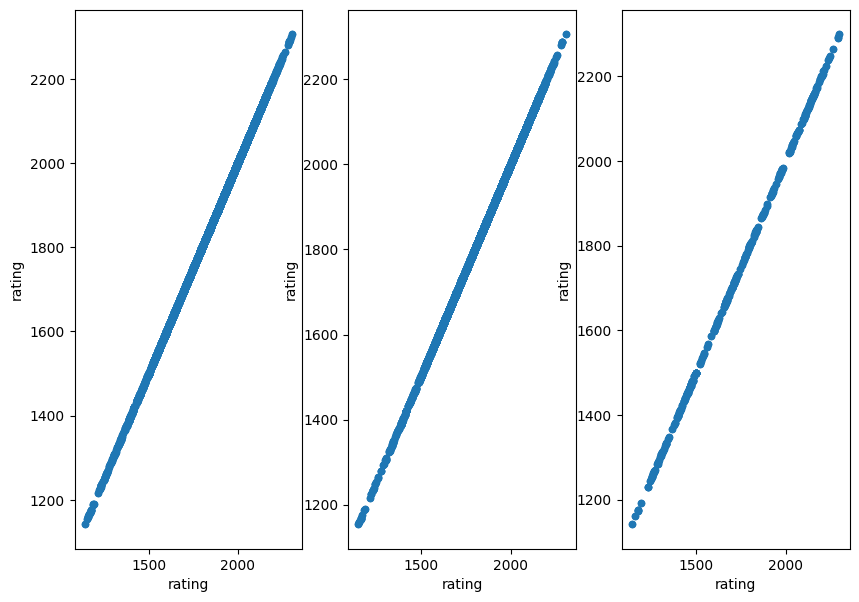

In [51]:
numerical = ['game_duration_seconds', 'score', 'bot_rating', 'rating']
more_mask = (v_abs_error>200)
less_mask = ~more_mask

for i, check in enumerate(numerical):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 7))
    v_data[[check, 'rating']].plot.scatter(x=check, y='rating', ax=axes[0])
    v_data[less_mask][[check, 'rating']].plot.scatter(x=check, y='rating', ax=axes[1])
    v_data[more_mask][[check, 'rating']].plot.scatter(x=check, y='rating', ax=axes[2])

In [50]:
print(v_data.shape[0])
v_data[(v_abs_error > 150)]

5041


first time_control_name game_end_reason  winner  \
game_id                                                       
58356     STEEBot           regular        STANDARD       0   
20888     STEEBot           regular            TIME       0   
15884      KoalaJ           regular        STANDARD       1   
44171     STEEBot           regular            TIME       0   
28816    daylight           regular        STANDARD       0   
...           ...               ...             ...     ...   
49117     STEEBot           regular        STANDARD       0   
7998        Mimix           regular        STANDARD      -1   
38774     BethMix           regular        STANDARD       0   
43146      rameez           regular        STANDARD       0   
60960      wagyus           regular        STANDARD       0   

                  created_at lexicon  initial_time_seconds  increment_seconds  \
game_id                                                                         
58356    2022-08-12 10:39:55   CSW21                  1800                  0   
20888    2022-09-02 21:57:43   CSW21                   900                  0   
15884    2022-09-05 03:10:53   CSW21                  1200                  0   
44171    2022-09-21 04:40:31   CSW21                   900                  0   
28816    2022-09-15 13:50:00   CSW21                  1200                  0   
...                      ...     ...                   ...                ...   
49117    2022-08-26 12:29:08   CSW21                  1200                  0   
7998     2022-08-21 05:04:08   CSW21                  1200                  0   
38774    2022-08-07 01:32:07   CSW21                  1200                  0   
43146    2022-08-30 17:14:52   NWL20                  1200                  0   
60960    2022-08-28 05:18:14   CSW21                  1200                  0   

        rating_mode  max_overtime_minutes  game_duration_seconds  bot_rating  \
game_id                                                                        
58356         RATED                     1            1354.176891        2093   
20888         RATED                     2            1023.738961        2124   
15884         RATED                     1             480.022579        2147   
44171         RATED                     1             960.676432        2111   
28816        CASUAL                     1             550.721136        2038   
...             ...                   ...                    ...         ...   
49117         RATED                     1             575.012034        2072   
7998          RATED                     1             269.972776        2004   
38774         RATED                     1             414.732004        1915   
43146         RATED                     1             129.329145        2043   
60960         RATED                     1             246.885287        2168   

          bot_name  score  rating   abs_error         pred       error  
game_id                                                                 
58356      STEEBot    317    2072  259.295654  1812.704346 -259.295654  
20888      STEEBot    293    2186  318.413452  1867.586548 -318.413452  
15884      STEEBot    493    2148  151.677979  1996.322021 -151.677979  
44171      STEEBot    266    2019  299.011719  1719.988281 -299.011719  
28816    BetterBot    357    1925  195.949951  1729.050049 -195.949951  
...            ...    ...     ...         ...          ...         ...  
49117      STEEBot    320    2020  201.578735  1818.421265 -201.578735  
7998     BetterBot    442    1774  228.452393  2002.452393  228.452393  
38774    BetterBot    374    1491  456.655396  1947.655396  456.655396  
43146     HastyBot    354    1545  168.311035  1713.311035  168.311035  
60960     HastyBot    345    2146  164.270996  1981.729004 -164.270996  

[637 rows x 18 columns]

testing something else...

In [99]:
t_data = regressor[:-1].transform(n_data)
X1, X2, y1, y2 = train_test_split(t_data, n_ratings, test_size=0.95, random_state=42)

classifer =XGBClassifier(random_state=0,)
classifer.fit(X1, (y1 == 1500).astype(int))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [100]:
c_pred = classifer.predict(t_data)
accuracy_score(c_pred, n_ratings == 1500)

0.9865701249752034

In [101]:
X2['bigger'] = classifer.predict(X2)

In [102]:
new_regressor = XGBRegressor(random_state=0,
                                        max_depth=7, min_child_weight=1,
                                        gamma=0,
                                        subsample=1, colsample_bytree=1,
                                        reg_alpha=0.00005, reg_lambda=1,
                                        learning_rate=np.sqrt(3)/10)
new_regressor.fit(X2, y2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.17320508075688773,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [103]:
test = t_data.assign(**{'bigger': classifer.predict(t_data)})
new_prediction = new_regressor.predict(test)

In [104]:
mean_squared_error(n_ratings, new_prediction, squared=False)

88.20547965603815

In [105]:
cv_res = cross_validate(new_regressor, X2, y2, cv=5,
                         scoring=('neg_root_mean_squared_error'),
                         return_train_score=True,)

In [106]:
pd.DataFrame(cv_res).mean()

fit_time         4.815035
score_time       0.021097
test_score    -105.798706
train_score    -85.111647
dtype: float64